In [ ]:
!pip install -q -r requirements.txt
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler


import datapackage
from functools import reduce
import world_bank_data as wb
import requests
# Plotting libraries
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
#import tabula
#from tabula import read_pdf

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


# Feature Engineering & cleaning 

## Data Loading & Cleaning

| Field      | Frequency | Source    |
| :---        |    :----:   |    :---: |
|Total Debt - gross external debt as % of GDP|	Q|	QEDS|
|Short-Term Debt - gross short-term external debt as % of GDP|	Q|	QEDS|
|Real Interest Rate - lending interest rate adjusted for inflation|	Q|	IMF - IFS|
|Foreign Exchange Reserves - total reserves (without gold) as % of GDP|	Q|	IMF - IFS|
|Trade Openness - ratio of exports plus imports to GDP|	Q|	IMF - IFS|
|Imports - imports of goods and services at current prices in USD|	Q|	IMF - IFS|
|Exports - exports of goods and services at current prices in USD|	Q|	IMF - IFS|
|Current Account - current account balance as % of GDP|	A|	See BoP from IMF Website - see 'BSA_BP6_USD'|
|Portfolio Investments - portfolio investment net at current USD|	Q|	IMF - IFS|
|FDI - net FDI inflows as % of GDP|	A|	World Bank - WDI|
|Real GDP - annual real GDP at current USD|	A|	World Bank - WDI|
|Real GDP Growth - annual growth of real GDP|A|	World Bank - WDI|
|Inflation - rate of change in CPI|A|	World Bank - WDI - TBC|
|Money Plus Quasi Money(M2) -from Monetary & Financial statistics |?|	IMF - MFS - See '35L__USD'|
|M2 Multiplier Growth - annual growth of M2|	A|	World Bank - WDI|
|M2/Reserves - ratio of M2 to foreign exchange reserves|	A|	World Bank - WDI|
|REER Overall - deviation of real effective exchange rate from 5 year rolling mean|	A|	World Bank - WDI|
|Government Spending - general government final spending as % of GDP|	A|	World Bank - WDI - Check National Sources|
|Fixed Capital Formation - gross fixed capital formation at current USD|	A|	World Bank - WDI - Check National Sources|
|Unemployment - unemployment total as % of total labor force|	A|	World Bank - TBC - check OECD|
|Contagion - event of a currency crisis in any country of the same region (t − 1)|	|	Derived|
|Soft Peg 2 - exchange rate regime applied to currency to keep its value stable against a reserve currency|	|	n/a|
|Peg 2 - exchange rate regime in which a currency’s value is fixed against either the value of another country’s currency|	|	n/a|
|Domestic Credit - ratio of domestic credit to GDP|	Q|	IMF - IFS|
|Lending Interest Rate - the bank rate meets the short- and medium-term financing needs|	Q|	IMF - IFS|
|Deposit Interest Rate - rate paid by banks for demand, time, or savings deposits|	Q|	IMF - IFS|
|Polity - combined polity score (autocracy score minus democracy score)|	|	|


### Country data 
Additional data required to join WDI & IFS data on common country code.
Data needs to be reformatted into a mapping for IFS & WEO to be joined on same country code.

In [ ]:

WOE_Dataset = pd.read_csv('IMF_country_codes.csv')
def WEO_country(WOE_Dataset):
    # Get ride of unused data
    WOE_Dataset.drop(columns= WOE_Dataset.columns[4:] , inplace=True)
    #rename columns
    old_columns = WOE_Dataset.columns
    New_columns = WOE_Dataset.iloc[0].to_list()
    rename_map = dict(zip(old_columns, New_columns))
    WOE_Dataset.rename(columns = rename_map, inplace = True)

    #Drop column 0 - the true header
    WOE_Dataset = WOE_Dataset.drop(0).copy()
    WOE_Dataset['IMF Code'] = WOE_Dataset['IMF Code'].astype(int)
    return WOE_Dataset 

In [ ]:
cntry_map = pd.read_csv('IMF_country_codes.csv')
cntry_map = WEO_country(cntry_map)

### World Bank Database
#### World Develpment Indicators (WDI) Data - The World Bank
Notes on outstanding work: 1 - Make Data DateTime Object. 2 - concat the Indicator code to the title name

#### World Development Indicators data Cleaning Function

Used for loading WDI CSV format



In [ ]:
def clean_wdi_data(dataset, countries, date_from = 1980, date_to = 2002 ):
    '''
    dataset {df}: WDI Data sample
    countries {List}: List of countries to be inclided in Dataset
    date_from {int}: Lowest year - default 1980
    date_to {int}: Highest Yeat - default 2020

    Output{df}: Year, Country Name , Country Code, [Series Names]

    '''
    #Clean titles
    #Create Dictionary of column header mapping & use rename function
    old_columns = dataset.columns[4::]
    yr_columns = dataset.columns[4::].str[:4]
    yr_columns_dict = dict(zip(old_columns, yr_columns))
    dataset.rename(columns = yr_columns_dict, inplace = True)
    
    #Country Selection
    dataset = dataset[dataset['Country Name'].isin(countries)].copy()
    
    #Reform Pivotted Data
    dataset.drop([ 'Series Code'], axis=1, inplace = True)
    dataset = dataset.melt(id_vars=['Country Name','Country Code','Series Name'], var_name='Year', value_name='Value' ).copy()
    dataset = dataset.pivot(index=['Year', 'Country Name', 'Country Code'], columns='Series Name', values='Value').reset_index().copy()
    dataset.rename(columns = {'Country Code':'ISO Code'}, inplace = True)

    return dataset

In [ ]:
WOE_raw = pd.read_csv('WDI - sample.csv')

In [ ]:
#wdi_sample = pd.read_csv('WDI - sample.csv') 
#wdi_sample.head()

WOE_test = WOE_raw.copy()
WOE_cntry = ['Mexico']
WOE_test = clean_wdi_data(WOE_test, WOE_cntry, date_from = 1980, date_to = 2002 )
WOE_test.head()

Series Name  Year Country Name ISO Code Broad money growth (annual %)  \
0            1980       Mexico      MEX              38.2095425479587   
1            1981       Mexico      MEX              50.2313331909744   
2            1982       Mexico      MEX              54.3636880507912   
3            1983       Mexico      MEX              63.5052179251074   
4            1984       Mexico      MEX              69.1008072085602   

Series Name Broad money to total reserves ratio  \
0                               14.629444229092   
1                              17.3289922156437   
2                              32.4963549954408   
3                              9.25319657918963   
4                              6.69471656817234   

Series Name Gross capital formation (constant 2010 US$)  \
0                                      166675198325.232   
1                                      192020235587.809   
2                                      145050911386.683   
3                                      105378925920.693   
4                                      111104213319.661   

Series Name Real effective exchange rate index (2010 = 100)  
0                                          120.847948707833  
1                                          137.506499561169  
2                                          98.7235493103745  
3                                          86.9998506207057  
4                                          101.900803271927

#### World Bank API access to load fields per country

Used for loading WDI directly


In [ ]:
pd.DataFrame(wb.get_series('DP.DOD.DECN.CR.GG.Z1', date='1980:2020', id_or_value='id', simplify_index=True)).reset_index()

dfs = [ pd.DataFrame(wb.get_series('DP.DOD.DECN.CR.GG.Z1', date='1980:2020', id_or_value='id', simplify_index=True)).reset_index(), #Total_Debt
        pd.DataFrame(wb.get_series('DP.DOD.DSTC.CR.GG.Z1', date='1980:2020', id_or_value='id', simplify_index=True)).reset_index(), #Shrt_Trm_Debt
        Call_IMF('BOP',freq='Q',Country_iso2= 'GB', start=2005, finish=2020, Indicator_code='BCAXF_BP6_USD'), # No M Availability - Needs Interpolation 
        Call_IMF('BOP',freq='Q',Country_iso2= 'GB', start=2005, finish=2020, Indicator_code='BFDLXF_BP6_USD')
        ]

df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Year'],
                                            how='outer'), dfs).fillna(np.NaN)
df_merged

### QEDS Data

Loading 'Quarterly Public Sector Debt', 'Quarterly External Debt Statistics SDDS', 'Quarterly External Debt Statistics GDDS'data using the WOE API

DP.DOD.DECN.CR.GG.Z1 = Gross PSD, General Gov., All maturities, All instruments, Domestic currency, Nominal Value, % of GDP #Quarterly Public Sector Debt

DP.DOD.DSTC.CR.GG.Z1 = Gross PSD, General Gov., Short-term, All instruments, Nominal Value, % of GDP #Quarterly Public Sector Debt

In [ ]:
Total_Debt= pd.DataFrame(wb.get_series('DP.DOD.DECN.CR.GG.Z1', date='1980:2020', id_or_value='id', simplify_index=True)).reset_index()
Shrt_Trm_Debt  = pd.DataFrame(wb.get_series('DP.DOD.DSTC.CR.GG.Z1', date='1980:2020', id_or_value='id', simplify_index=True)).reset_index()



Shrt_Trm_Debt.head()

Country    Year  DP.DOD.DSTC.CR.GG.Z1
0     ALB  1995Q1                   NaN
1     ALB  1995Q2                   NaN
2     ALB  1995Q3                   NaN
3     ALB  1995Q4                   NaN
4     ALB  1996Q1                   NaN

In [ ]:
QEDS = pd.merge(Total_Debt, Shrt_Trm_Debt, left_on=['Country', 'Year'], right_on=['Country', 'Year'], how = 'outer' )
QEDS.rename(columns = {'Country':'ISO Code',
'DP.DOD.DECN.CR.GG.Z1':'Gross PSD, General Gov., All maturities, All instruments, Domestic currency, Nominal Value, % of GDP- DP.DOD.DECN.CR.GG.Z1',
'DP.DOD.DSTC.CR.GG.Z1':'Gross PSD, General Gov., Short-term, All instruments, Nominal Value, % of GDP - DP.DOD.DSTC.CR.GG.Z1'
                        }, inplace = True)
QEDS

ISO Code    Year  \
0          ALB  1995Q1   
1          ALB  1995Q2   
2          ALB  1995Q3   
3          ALB  1995Q4   
4          ALB  1996Q1   
...        ...     ...   
10603      URY  2019Q4   
10604      URY  2020Q1   
10605      URY  2020Q2   
10606      URY  2020Q3   
10607      URY  2020Q4   

       Gross PSD, General Gov., All maturities, All instruments, Domestic currency, Nominal Value, % of GDP- DP.DOD.DECN.CR.GG.Z1  \
0                                                    NaN                                                                            
1                                                    NaN                                                                            
2                                                    NaN                                                                            
3                                                    NaN                                                                            
4                                                    NaN                                                                            
...                                                  ...                                                                            
10603                                                NaN                                                                            
10604                                                NaN                                                                            
10605                                                NaN                                                                            
10606                                                NaN                                                                            
10607                                                NaN                                                                            

       Gross PSD, General Gov., Short-term, All instruments, Nominal Value, % of GDP - DP.DOD.DSTC.CR.GG.Z1  
0                                                    NaN                                                     
1                                                    NaN                                                     
2                                                    NaN                                                     
3                                                    NaN                                                     
4                                                    NaN                                                     
...                                                  ...                                                     
10603                                                NaN                                                     
10604                                                NaN                                                     
10605                                                NaN                                                     
10606                                                NaN                                                     
10607                                                NaN                                                     

[10608 rows x 4 columns]

### International Financial Statistics (IFS DB) data - International Monetary Fund
Notes on outstanding work: 1 - Make Data DateTime Object. 2 - concat the Indicator code to the title name. 3 - Need to Edit the Indicators being used. 

| Field      | Indicator Code | Source    |
| :---        |    :----:   |    :---: |
| Header      | Title       | Here's this   |
| Paragraph   | Text        | And more      |

In [ ]:
def clean_IFS_data(dataset, countries, frequency, date_from, Series_Codes , date_to):
    '''
    dataset {df}: WDI Data sample
    countries {List}: List of countries to be inclided in Dataset
    date_from {int}: Lowest year - default 1980
    date_to {int}: Highest Yeat - default 2020

    Output{df}: 'Year', 'Country Name', 'Country Code', [Series Names]

    '''
    #Country Selection
    dataset = dataset[dataset['Country Name'].isin(countries)].copy()   

    #Concat Base year & Drop Base Year Column
    dataset['Indicator Name'] = np.where(dataset['Base Year'].isnull(),dataset['Indicator Name'], dataset['Indicator Name'] + " (" + dataset['Base Year'] +")").copy()
    
    # Filter by then concat the Indicator Code
    dataset = dataset[dataset['Indicator Code'].isin(Series_Codes)].copy()
    dataset['Indicator Name'] = dataset['Indicator Name'] + " - " + dataset['Indicator Code']

    dataset = dataset[dataset['Attribute']!='Status'].copy()
    
    dataset.drop(['Base Year', 'Indicator Code', 'Attribute'], axis=1, inplace = True)


    #Melt Data 
    dataset = dataset.melt(id_vars=['Country Name','Country Code','Indicator Name'], var_name='Year', value_name='Value' ).copy()

    #Frequency - Annual - Done
    if frequency == 'Y':
        non_ann = ['M', 'Q']
        dataset = dataset[~dataset.Year.str.contains('|'.join(non_ann))].copy()
    elif frequency == 'Q':
        dataset = dataset[dataset.Year.str.contains('Q')].copy()
    elif frequency == 'M':
        dataset = dataset[dataset.Year.str.contains('M')].copy()

    #Pivot Indicators to Columns
    dataset['Value'] = dataset['Value'].astype(float)
    dataset = dataset.groupby(['Year', 'Country Name', 'Country Code', 'Indicator Name']).agg({'Value':'sum'}).reset_index().copy()
    dataset = dataset.pivot(index=['Year', 'Country Name', 'Country Code'], columns='Indicator Name', values='Value').reset_index().copy()
    dataset.rename(columns = {'Country Code':'IMF Code'}, inplace = True)

    return dataset

IMF Load Function Test:

In [ ]:
# Don't run - too big!
IFS_DB =  pd.read_csv('IFS_timeSeries_1980_2020.csv')
IFS_DB.head()

In [ ]:
Countries = ['Mexico']

IMF_Indicators =['FILR_PA'
                ,'RAXGFX_USD'
                ,'NM_XDC' 
                ,'TMG_CIF_USD'
                ,'TXG_FOB_USD'
                ,'IAP_BP6_USD']
X = clean_IFS_data(IFS_DB, countries = Countries, date_from = 1980, Series_Codes = IMF_Indicators , date_to = 2002, frequency = 'Q' )
X.head(100)

Indicator Name    Year  Country Name  Country Code  \
0               1980Q1  South Africa           199   
1               1980Q1      Thailand           578   
2               1980Q1        Turkey           186   
3               1980Q2  South Africa           199   
4               1980Q2      Thailand           578   
..                 ...           ...           ...   
95              1987Q4        Turkey           186   
96              1988Q1  South Africa           199   
97              1988Q1      Thailand           578   
98              1988Q1        Turkey           186   
99              1988Q2  South Africa           199   

Indicator Name  Assets, Portfolio Investment, US Dollars - IAP_BP6_USD  \
0                                                             0.0        
1                                                             0.0        
2                                                             0.0        
3                                                             0.0        
4                                                             0.0        
..                                                            ...        
95                                                            0.0        
96                                                            0.0        
97                                                            0.0        
98                                                            0.0        
99                                                            0.0        

Indicator Name  External Balance of Goods and Services, Imports of Goods and Services, Nominal, Domestic Currency - NM_XDC  \
0                                                             0.0                                                            
1                                                             0.0                                                            
2                                                             0.0                                                            
3                                                             0.0                                                            
4                                                             0.0                                                            
..                                                            ...                                                            
95                                                      4905000.0                                                            
96                                                            0.0                                                            
97                                                            0.0                                                            
98                                                      4450000.0                                                            
99                                                            0.0                                                            

Indicator Name  External Trade, Goods, Value of Exports, Free on Board (FOB), US Dollars - TXG_FOB_USD  \
0                                                    6.502265e+09                                        
1                                                    1.928077e+09                                        
2                                                    7.140100e+08                                        
3                                                    5.783546e+09                                        
4                                                    1.551523e+09                                        
..                                                            ...                                        
95                                                   3.321600e+09                                        
96                                                   5.321618e+09                                    

### IMF & WB API for data gathering

In [ ]:
def Call_IMF(DB,freq,Country_iso2, start, finish, Indicator_code):
    core = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/'
    key = f'{DB}/{freq}.{Country_iso2}.{Indicator_code}'
    time = f'.?startPeriod={start}&endPeriod={finish}'
    url = f'{core}{key}{time}'

    # Get data from the above URL using the requests package
    data = requests.get(url).json()

    # Load data into a pandas dataframe
    series = pd.DataFrame(data['CompactData']['DataSet']['Series']['Obs'])
    series['@OBS_VALUE'] = series['@OBS_VALUE'].astype(float)
    series.rename(columns = {'@TIME_PERIOD':'Year', '@OBS_VALUE':Indicator_code}, inplace = True)
    return series

In [ ]:
def Call_WB(iso3, id,start, finish):
    daterange = f'{start}:{finish}'
    Data = pd.DataFrame(wb.get_series(id, date=daterange, id_or_value='id', simplify_index=True)).reset_index()
    Data = Data[Data['Country']==iso3]
    return Data

Data availability: Annual 

In [ ]:
Call_WB('GBR', 'NY.GDP.MKTP.CD',2004, 2020)

Country  Year  NY.GDP.MKTP.CD
4318     GBR  2004    2.412133e+12
4319     GBR  2005    2.532804e+12
4320     GBR  2006    2.706081e+12
4321     GBR  2007    3.093583e+12
4322     GBR  2008    2.921613e+12
4323     GBR  2009    2.412317e+12
4324     GBR  2010    2.481580e+12
4325     GBR  2011    2.659882e+12
4326     GBR  2012    2.704017e+12
4327     GBR  2013    2.783251e+12
4328     GBR  2014    3.065521e+12
4329     GBR  2015    2.932785e+12
4330     GBR  2016    2.693248e+12
4331     GBR  2017    2.662573e+12
4332     GBR  2018    2.857508e+12
4333     GBR  2019    2.830814e+12
4334     GBR  2020    2.707744e+12

In [ ]:
from functools import reduce
dfs_An= [Call_WB('AFE', 'FM.LBL.BMNY.ZG',1980, 2020), # M2 USD
        Call_WB('AFE', 'NY.GDP.MKTP.CD',1980, 2020), #GDP USD
        Call_WB('AFE', 'NE.GDI.FTOT.CD',1980, 2020),

        ]

df_merged_An = reduce(lambda  left,right: pd.merge(left,right,on=['Year'],
                                            how='outer'), dfs_An).fillna(np.NaN)
df_merged

Data availability: Quarterly

Data availability: Annual 

In [ ]:
from functools import reduce
dfs = [ Call_IMF('IFS',freq='M',Country_iso2= 'GB', start=2005, finish=2020, Indicator_code='FILR_PA'), # Monthly available 
        Call_IMF('IFS',freq='M',Country_iso2= 'GB', start=2005, finish=2020, Indicator_code='RAXGFX_USD'), # Monthly available 
        #Call_IMF('IFS',freq='M',Country_iso2= 'GB', start=2005, finish=2020, Indicator_code='NM_XDC') # No data anyway
        Call_IMF('IFS',freq='M',Country_iso2= 'GB', start=2005, finish=2020, Indicator_code='TMG_CIF_USD'), # Monthly available 
        Call_IMF('IFS',freq='Q',Country_iso2= 'GB', start=2005, finish=2020, Indicator_code='TXG_FOB_USD'), # Monthly available 
        #Call_IMF('IFS',freq='M',Country_iso2= 'GB', start=2005, finish=2020, Indicator_code='IAP_BP6_USD'),# No M Availability but this a set rate, so this can just
        
        #CURRENT ACCOUNT
        Call_IMF('BOP',freq='Q',Country_iso2= 'GB', start=2005, finish=2020, Indicator_code='BCAXF_BP6_USD'), # No M Availability - Needs Interpolation 
        Call_IMF('BOP',freq='Q',Country_iso2= 'GB', start=2005, finish=2020, Indicator_code='BFDLXF_BP6_USD')
        ]

df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Year'],
                                            how='outer'), dfs).fillna(np.NaN)
df_merged

Year  FILR_PA    RAXGFX_USD   TMG_CIF_USD    TXG_FOB_USD  \
0    2005-01     4.75  32349.015601  38573.258486            NaN   
1    2005-02     4.75  32311.455005  38078.970216            NaN   
2    2005-03     4.75  33493.495904  42655.437206            NaN   
3    2005-04     4.75  32478.503758  42533.439430            NaN   
4    2005-05     4.75  32711.145373  39642.333191            NaN   
..       ...      ...           ...           ...            ...   
251  2019-Q4      NaN           NaN           NaN  113364.061025   
252  2020-Q1      NaN           NaN           NaN  102106.394461   
253  2020-Q2      NaN           NaN           NaN   76204.886927   
254  2020-Q3      NaN           NaN           NaN   93545.173018   
255  2020-Q4      NaN           NaN           NaN  109273.166010   

     BCAXF_BP6_USD  BFDLXF_BP6_USD  
0              NaN             NaN  
1              NaN             NaN  
2              NaN             NaN  
3              NaN             NaN  
4              NaN             NaN  
..             ...             ...  
251    4738.592581   -36177.653821  
252  -22536.531387    17501.964977  
253  -14705.810018     5154.293949  
254  -21426.363009     -933.939860  
255  -36752.466614    -3649.545636  

[256 rows x 7 columns]

In [ ]:
#Call_IMF('IFS',freq='A',Country_iso2= 'GB', start=2005, finish=2020, Indicator_code='NGDP_R_CH_SA_XDC')
Call_IMF('IFS',freq='M',Country_iso2= 'GB', start=2005, finish=2020, Indicator_code='NFID_XDC')



#EREER_IX - REED Index - look up!!
#CURRENT ACCOUNT= BCAXF_BP6_USD
#FDI = BFDLXF_BP6_USD
#gdp DOMESTIC CURRENCY = NGDP_R_CH_SA_XDC


KeyError: 'Series'

In [ ]:
SPEND = pd.DataFrame(wb.get_series('NE.GDI.FTOT.CD', date='2004:2020', id_or_value='id', simplify_index=True)).reset_index()
SPEND[SPEND['Country']=='GBR']

Country  Year  NE.GDI.FTOT.CD
4318     GBR  2004    4.151379e+11
4319     GBR  2005    4.377759e+11
4320     GBR  2006    4.752794e+11
4321     GBR  2007    5.536568e+11
4322     GBR  2008    5.103846e+11
4323     GBR  2009    3.876531e+11
4324     GBR  2010    3.964991e+11
4325     GBR  2011    4.148118e+11
4326     GBR  2012    4.249037e+11
4327     GBR  2013    4.441105e+11
4328     GBR  2014    5.097464e+11
4329     GBR  2015    5.053996e+11
4330     GBR  2016    4.769127e+11
4331     GBR  2017    4.792074e+11
4332     GBR  2018    5.086497e+11
4333     GBR  2019    5.099374e+11
4334     GBR  2020    4.756233e+11

#### Function for calling all relevant data from IMF

In [ ]:
def Get_IMF_Data(iso2, srt, fin, term, frequency):
        #Money Market Rate
    if term == 'MMK': 
        indicator = 'FPOLM_PA'
        rate = 'Money Market Rate'
    #Treasury Bill Rate
    elif term == 'TB': 
        indicator = 'FITB_PA'
        rate = 'Treasury Bill Rate'
    # Central Bank Policy Rate
    elif term == 'central':
        indicator = 'FPOLM_PA'    
        rate = 'Central Bank Policy Rate'


    #Load core IFS Fields
    load_IMF = [Call_IMF('IFS',freq=frequency ,Country_iso2= iso2, start=srt, finish=fin, Indicator_code='FILR_PA'),
                Call_IMF('IFS',freq=frequency ,Country_iso2= iso2, start=srt, finish=fin, Indicator_code='RAXGFX_USD'),
                #Call_IMF('IFS',freq=frequency ,Country_iso2= iso2, start=srt, finish=fin, Indicator_code='NM_XDC'),
                Call_IMF('IFS',freq=frequency ,Country_iso2= iso2, start=srt, finish=fin, Indicator_code='TMG_CIF_USD'),
                Call_IMF('IFS',freq=frequency ,Country_iso2= iso2, start=srt, finish=fin, Indicator_code='TXG_FOB_USD'),
                Call_IMF('IFS',freq=frequency ,Country_iso2= iso2, start=srt, finish=fin, Indicator_code='IAP_BP6_USD'),
                Call_IMF('IFS',freq=frequency ,Country_iso2= iso2, start=srt, finish=fin, Indicator_code='35L___XDC'), #M2 (Domestic Currency)
                Call_IMF('IFS',freq=frequency ,Country_iso2= iso2, start=srt, finish=fin, Indicator_code='RAXG_USD'), #Total Reserves (USD)
                Call_IMF('CPI',freq=frequency,Country_iso2= iso2, start=srt, finish=fin, Indicator_code='PCPI_IX'), #CPI - INFLATION
                Call_IMF('IFS',freq=frequency,Country_iso2= iso2, start=srt, finish=fin, Indicator_code='LUR_PT'), #Unemployment rate
                Call_IMF('IFS',freq=frequency,Country_iso2= iso2, start=srt, finish=fin, Indicator_code='EREER_IX'), #REED Index
                Call_IMF('IFS',freq=frequency,Country_iso2= iso2, start=srt, finish=fin, Indicator_code=indicator),
                Call_IMF('IFS',freq=frequency,Country_iso2= iso2, start=srt, finish=fin, Indicator_code='ENDA_XDC_USD_RATE'),#Exchange Rate to USD
                Call_IMF('IFS',freq=frequency,Country_iso2='US', start=srt, finish=fin, Indicator_code= indicator)
            
            ]

    merged_IMF = reduce(lambda  left,right: pd.merge(left,right,on=['Year'],how='outer'), load_IMF).fillna(np.NaN)    



    #  Create Classification
    merged_IMF['% Diff'] = merged_IMF['ENDA_XDC_USD_RATE'].pct_change().copy()
    merged_IMF['FPOLM_PA_x'] = (1+(merged_IMF['FPOLM_PA_x']/100))
    merged_IMF['FPOLM_PA_y'] = (1+(merged_IMF['FPOLM_PA_y']/100))

    merged_IMF['rate ratio'] =  merged_IMF['FPOLM_PA_x']/merged_IMF['FPOLM_PA_y'] 
    merged_IMF['gamma'] = 100 * merged_IMF['% Diff'] * merged_IMF['rate ratio']
    merged_IMF['std scaler'] = (merged_IMF['gamma']-merged_IMF['gamma'].mean())/merged_IMF['gamma'].std()
    cut_labels = ['Green', 'Yellow', 'Orange', 'Red']
    cuts = [-50,5,10,15,1000]
    merged_IMF['quantiles'] = pd.cut(merged_IMF['gamma'],
                              bins=cuts,
                              labels=cut_labels)

    return merged_IMF

#### Function For calling all fields for multiple countries to be used for classification

In [ ]:
def Multi_Call_IMF(DB,freq,iso2_list, start, finish, Indicator_code):
    countries = "+".join(iso2_list)    
    core = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/'
    key = f'{DB}/{freq}.{countries}.{Indicator_code}'
    time = f'.?startPeriod={start}&endPeriod={finish}'
    url = f'{core}{key}{time}'

    # Get data from the above URL using the requests package
    data = requests.get(url).json()

    # Load data into a pandas dataframe
    #series = pd.DataFrame(data['CompactData']['DataSet']['Series']['Obs'])


    appended_data = []
    for c in range(len(iso2_list)):
        series = pd.DataFrame(data['CompactData']['DataSet']['Series'][c]['Obs'])
        country_idx = (data['CompactData']['DataSet']['Series'][c]['@REF_AREA'])
        series['Country']= country_idx
        series['@OBS_VALUE']=series['@OBS_VALUE'].astype(float)
        appended_data.append(series)

    appended_data = pd.concat(appended_data)
    appended_data

    appended_data = appended_data[['@TIME_PERIOD','Country','@OBS_VALUE']]
    appended_data.rename(columns = {'@TIME_PERIOD':'Year', '@OBS_VALUE':Indicator_code}, inplace = True)
    
    return appended_data

In [ ]:
Get_IMF_Data('GB', 2004, 2012, 'central', 'Q')

Year   FILR_PA    RAXGFX_USD    TMG_CIF_USD    TXG_FOB_USD  \
0   2004-Q1  3.904167  29519.325451  109348.861956   82257.718556   
1   2004-Q2  4.210333  28654.025391  111108.528750   83474.781844   
2   2004-Q3  4.654767  29614.790844  113789.111711   85096.150843   
3   2004-Q4  4.750000  34081.740954  122322.288593   94675.442346   
4   2005-Q1  4.750000  33493.495904  119307.665908   89093.339923   
5   2005-Q2  4.750000  34161.027354  123887.605585   96717.776902   
6   2005-Q3  4.594700  35172.491657  122144.243821   94388.559698   
7   2005-Q4  4.500000  35853.947386  123618.993159  100761.785596   
8   2006-Q1  4.500000  36274.856768  133803.348925  114185.312309   
9   2006-Q2  4.500000  38235.090615  143891.574510  129289.107302   
10  2006-Q3  4.659100  38527.271060  139020.782848  101792.123976   
11  2006-Q4  4.893933  38888.556564  143807.700404  105586.618580   
12  2007-Q1  5.223500  41848.717362  147603.755552  103926.802169   
13  2007-Q2  5.392867  40874.255947  152241.887023  110270.380547   
14  2007-Q3  5.738633  41620.195705  159015.517675  108913.566138   
15  2007-Q4  5.679833  47497.779814  167002.984905  119366.970448   
16  2008-Q1  5.349200  49205.161003  164089.171894  116972.335119   
17  2008-Q2  5.026500  46751.905586  176071.289972  128531.985211   
18  2008-Q3  5.000000  40673.316744  168038.795076  122573.061092   
19  2008-Q4  3.325533  41550.312208  130579.535027   96169.486084   
20  2009-Q1  1.079467  37068.777000  108748.852355   77622.004443   
21  2009-Q2  0.500000  41158.104000  115952.253533   84244.663858   
22  2009-Q3  0.500000  39736.239000  124987.805270   91136.657059   
23  2009-Q4  0.500000  38026.000000  134527.434402  100623.443199   
24  2010-Q1  0.500000  40221.325000  131288.499877   95298.068074   
25  2010-Q2  0.500000  43568.189000  132374.219787   97821.607916   
26  2010-Q3  0.500000  48140.075000  142542.641532  101423.837576   
27  2010-Q4  0.500000  49334.840000  154161.027975  111772.329774   
28  2011-Q1  0.500000  53545.475000  153350.090937  116174.509827   
29  2011-Q2  0.500000  57621.384000  159866.192104  119782.301487   
30  2011-Q3  0.500000  56588.339000  162003.330709  116559.507554   
31  2011-Q4  0.500000  56238.579000  160970.124204  121643.800530   
32  2012-Q1  0.500000  58653.889000  160702.296652  119845.133018   
33  2012-Q2  0.500000  60808.522000  158605.770662  114714.062656   
34  2012-Q3  0.500000  63911.655000  157783.921139  115483.111260   
35  2012-Q4  0.500000  64947.351000  161326.955097  117899.090586   

     IAP_BP6_USD  FPOLM_PA_x  ENDA_XDC_USD_RATE  FPOLM_PA_y    % Diff  \
0   1.858924e+06      1.0400           0.543917     1.01000       NaN   
1   1.855161e+06      1.0450           0.554003     1.01250  0.018545   
2   1.933570e+06      1.0475           0.550180     1.01750 -0.006901   
3   2.183809e+06      1.0475           0.536620     1.02250 -0.024646   
4   2.184072e+06      1.0475           0.528497     1.02750 -0.015138   
5   2.218206e+06      1.0475           0.538710     1.03250  0.019325   
6   2.342460e+06      1.0450           0.560673     1.03750  0.040770   
7   2.421179e+06      1.0450           0.572113     1.04250  0.020404   
8   2.643361e+06      1.0450           0.570613     1.04750 -0.002622   
9   2.803237e+06      1.0450           0.547853     1.05250 -0.039887   
10  2.948926e+06      1.0475           0.533570     1.05250 -0.026071   
11  3.299302e+06      1.0500           0.521910     1.05250 -0.021853   
12  3.455659e+06      1.0525           0.511663     1.05250 -0.019633   
13  3.725162e+06      1.0550           0.503433     1.05250 -0.016085   
14  3.807491e+06      1.0575           0.495140     1.04750 -0.016474   
15  3.786702e+06      1.0550           0.488850     1.04250 -0.012703   
16  3.602156e+06      1.0525           0.505363     1.02250  0.033780   
17  3.415130e+06      1.0500           0.507603     1.02000  0.004432   
18  3.012703e+06      1.0500           0.524150     1.02000  0.032

Useful code to find data type for each value in the dataframe

### Upsampling Annualised data

In [ ]:

Resample = pd.DataFrame({'Period':pd.Series(pd.date_range(start ='1980', end = '2020', freq="Q")).dt.to_period('Q')})
Resample.head()

Period
0  1980Q1
1  1980Q2
2  1980Q3
3  1980Q4
4  1981Q1

In [ ]:
Resample['Year'] =Resample['Period'].dt.year
Resample.head()

Period  Year
0  1980Q1  1980
1  1980Q2  1980
2  1980Q3  1980
3  1980Q4  1980
4  1981Q1  1981

Resample using the pythonic resample method

In [ ]:
HUN = WOE_test[WOE_test['ISO Code']=='HUN'].copy()
HUN['Year'] = pd.to_datetime(HUN.Year)#.dt.year
HUN.drop(columns = ['Country Name', 'ISO Code'], inplace=True, axis = 1)
HUN.head(10)

Series Name       Year Broad money growth (annual %)  \
0           1980-01-01                            ..   
2           1981-01-01                            ..   
4           1982-01-01                            ..   
6           1983-01-01              2.28284278535535   
8           1984-01-01              5.10247052217855   
10          1985-01-01              10.9159710628826   
12          1986-01-01              8.76999337735054   
14          1987-01-01               9.6440893743427   
16          1988-01-01              2.19264295089691   
18          1989-01-01              16.5329578949102   

Series Name Broad money to total reserves ratio  \
0                                            ..   
2                                            ..   
4                                            ..   
6                              5.51699493635597   
8                              4.25815773895428   
10                             3.41163289220185   
12                             3.67354077289799   
14                             5.20919175776884   
16                             5.68005233145182   
18                             6.48933685941606   

Series Name Gross capital formation (constant 2010 US$)  \
0                                                    ..   
2                                                    ..   
4                                                    ..   
6                                                    ..   
8                                                    ..   
10                                                   ..   
12                                                   ..   
14                                                   ..   
16                                                   ..   
18                                                   ..   

Series Name Real effective exchange rate index (2010 = 100)  
0                                                        ..  
2                                                        ..  
4                                                        ..  
6                                                        ..  
8                                                        ..  
10                                                       ..  
12                                                       ..  
14                                                       ..  
16                                                       ..  
18                                                       ..

In [ ]:
HUN.set_index(['Year'],inplace=True)
#HUN = np.where(HUN == "..", np.NaN,HUN).copy()
HUN.replace("..",np.NaN, inplace=True)
HUN= HUN.astype(float)
HUN.head(5)

Series Name  Broad money growth (annual %)  \
Year                                         
1980-01-01                             NaN   
1981-01-01                             NaN   
1982-01-01                             NaN   
1983-01-01                        2.282843   
1984-01-01                        5.102471   

Series Name  Broad money to total reserves ratio  \
Year                                               
1980-01-01                                   NaN   
1981-01-01                                   NaN   
1982-01-01                                   NaN   
1983-01-01                              5.516995   
1984-01-01                              4.258158   

Series Name  Gross capital formation (constant 2010 US$)  \
Year                                                       
1980-01-01                                           NaN   
1981-01-01                                           NaN   
1982-01-01                                           NaN   
1983-01-01                                           NaN   
1984-01-01                                           NaN   

Series Name  Real effective exchange rate index (2010 = 100)  
Year                                                          
1980-01-01                                               NaN  
1981-01-01                                               NaN  
1982-01-01                                               NaN  
1983-01-01                                               NaN  
1984-01-01                                               NaN

In [ ]:
Qrt = HUN.resample('Q' ).bfill()
Qrt.tail(10)

Series Name  Broad money growth (annual %)  \
Year                                         
2017-12-31                       11.815750   
2018-03-31                        8.149967   
2018-06-30                        8.149967   
2018-09-30                        8.149967   
2018-12-31                        8.149967   
2019-03-31                       20.894073   
2019-06-30                       20.894073   
2019-09-30                       20.894073   
2019-12-31                       20.894073   
2020-03-31                             NaN   

Series Name  Broad money to total reserves ratio  \
Year                                               
2017-12-31                              3.023984   
2018-03-31                              2.995998   
2018-06-30                              2.995998   
2018-09-30                              2.995998   
2018-12-31                              2.995998   
2019-03-31                                   NaN   
2019-06-30                                   NaN   
2019-09-30                                   NaN   
2019-12-31                                   NaN   
2020-03-31                                   NaN   

Series Name  Gross capital formation (constant 2010 US$)  \
Year                                                       
2017-12-31                                  3.649924e+10   
2018-03-31                                  4.029662e+10   
2018-06-30                                  4.029662e+10   
2018-09-30                                  4.029662e+10   
2018-12-31                                  4.029662e+10   
2019-03-31                                           NaN   
2019-06-30                                           NaN   
2019-09-30                                           NaN   
2019-12-31                                           NaN   
2020-03-31                                           NaN   

Series Name  Real effective exchange rate index (2010 = 100)  
Year                                                          
2017-12-31                                         90.144429  
2018-03-31                                         88.915411  
2018-06-30                                         88.915411  
2018-09-30                                         88.915411  
2018-12-31                                         88.915411  
2019-03-31                                         85.456919  
2019-06-30                                         85.456919  
2019-09-30                                         85.456919  
2019-12-31                                         85.456919  
2020-03-31                                               NaN

In [ ]:
Qrt2 = HUN.resample('Q' ).mean()
Qrt2.tail(10)

Series Name  Broad money growth (annual %)  \
Year                                         
2017-12-31                             NaN   
2018-03-31                       11.815750   
2018-06-30                             NaN   
2018-09-30                             NaN   
2018-12-31                             NaN   
2019-03-31                        8.149967   
2019-06-30                             NaN   
2019-09-30                             NaN   
2019-12-31                             NaN   
2020-03-31                       20.894073   

Series Name  Broad money to total reserves ratio  \
Year                                               
2017-12-31                                   NaN   
2018-03-31                              3.023984   
2018-06-30                                   NaN   
2018-09-30                                   NaN   
2018-12-31                                   NaN   
2019-03-31                              2.995998   
2019-06-30                                   NaN   
2019-09-30                                   NaN   
2019-12-31                                   NaN   
2020-03-31                                   NaN   

Series Name  Gross capital formation (constant 2010 US$)  \
Year                                                       
2017-12-31                                           NaN   
2018-03-31                                  3.649924e+10   
2018-06-30                                           NaN   
2018-09-30                                           NaN   
2018-12-31                                           NaN   
2019-03-31                                  4.029662e+10   
2019-06-30                                           NaN   
2019-09-30                                           NaN   
2019-12-31                                           NaN   
2020-03-31                                           NaN   

Series Name  Real effective exchange rate index (2010 = 100)  
Year                                                          
2017-12-31                                               NaN  
2018-03-31                                         90.144429  
2018-06-30                                               NaN  
2018-09-30                                               NaN  
2018-12-31                                               NaN  
2019-03-31                                         88.915411  
2019-06-30                                               NaN  
2019-09-30                                               NaN  
2019-12-31                                               NaN  
2020-03-31                                         85.456919

### Creating Full Dataset

Enriching IMF & WEO Data with the correct Country Code to allow for joinging

In [ ]:
cntry_map = pd.read_csv('IMF_country_codes.csv')
cntry_map = WEO_country(cntry_map)
cntry_map = cntry_map.iloc[:,0:2].copy()

In [ ]:
test_IFS = pd.read_csv('IFS sample.csv')

In [ ]:
cntrys = ['Afghanistan, Islamic Rep. of', 'Angola']
required_indicators = ['HPHSPA_PA']
test_IFS = clean_IFS_data(test_IFS, countries = cntrys, date_from = 1980, Series_Codes = required_indicators , date_to = 2002, frequency = 'Q' )
test_IFS.head()

Indicator Name    Year Country Name  IMF Code  \
0               1920Q1       Angola       614   
1               1920Q2       Angola       614   
2               1920Q3       Angola       614   
3               1920Q4       Angola       614   
4               1921Q1       Angola       614   

Indicator Name  Fund Accounts, SDR Holdings as % of Allocation, Percent per annum - HPHSPA_PA  
0                                                             0.0                              
1                                                             0.0                              
2                                                             0.0                              
3                                                             0.0                              
4                                                             0.0

In [ ]:
Full_data = pd.merge(test_IFS, cntry_map, left_on='IMF Code', right_on='IMF Code', how = 'left' ).head()
iso = Full_data["ISO Code"]
Full_data.drop("ISO Code",axis=1, inplace=True)
Full_data.insert(2, "ISO Code", iso)
Full_data

Year Country Name ISO Code  IMF Code  \
0  1920Q1       Angola      AGO       614   
1  1920Q2       Angola      AGO       614   
2  1920Q3       Angola      AGO       614   
3  1920Q4       Angola      AGO       614   
4  1921Q1       Angola      AGO       614   

   Fund Accounts, SDR Holdings as % of Allocation, Percent per annum - HPHSPA_PA  
0                                                0.0                              
1                                                0.0                              
2                                                0.0                              
3                                                0.0                              
4                                                0.0

In [ ]:
#test_IFS['Year'].apply(lambda x: type(x).__name__)
#test_IFS['Year'].to_period("Q")
#pd.to_datetime(df.date).dt.to_period('Q')
dt_test = test_IFS.copy()
dt_test.Year = pd.to_datetime(dt_test.Year).dt.to_period('Q')
#dt_test.set_index(pd.to_datetime(dt_test.Year).dt.to_period('Q'))
dt_test

Indicator Name    Year Country Name  IMF Code  \
0               1920Q1       Angola       614   
1               1920Q2       Angola       614   
2               1920Q3       Angola       614   
3               1920Q4       Angola       614   
4               1921Q1       Angola       614   
..                 ...          ...       ...   
401             2020Q2       Angola       614   
402             2020Q3       Angola       614   
403             2020Q4       Angola       614   
404             2021Q1       Angola       614   
405             2021Q2       Angola       614   

Indicator Name  Fund Accounts, SDR Holdings as % of Allocation, Percent per annum - HPHSPA_PA  
0                                                        0.000000                              
1                                                        0.000000                              
2                                                        0.000000                              
3                                                        0.000000                              
4                                                        0.000000                              
..                                                            ...                              
401                                                     73.423235                              
402                                                     71.369189                              
403                                                     68.548730                              
404                                                     65.359215                              
405                                                      0.000000                              

[406 rows x 4 columns]

Current Account

In [ ]:
Call_IMF(DB='BOP',freq='A',Country_iso2='GB', start='1980', finish='2020', Indicator_code='BSA_BP6_USD')

KeyError: 'Series'

#### IFS & QEDS Data Join

In [ ]:
Full_data = pd.merge(Full_data, QEDS, left_on=['Year','ISO Code'], right_on=['Year','ISO Code'], how = 'left' ).copy()

#### Converting WOE Data into Quarterly Periods

In [ ]:
pd.DataFrame([1, 2], index=pd.period_range('2012-01-01',
                                            freq='Q',
                                            periods=2)).reset_index()

index  0
0  2012Q1  1
1  2012Q2  2

In [ ]:
WOE_raw
old_columns = WOE_raw.columns[4::]
yr_columns = WOE_raw.columns[4::].str[:4]
yr_columns_dict = dict(zip(old_columns, yr_columns))
WOE_raw.rename(columns = yr_columns_dict, inplace = True)
WOE_raw

Country Name Country Code  \
0                                          Afghanistan          AFG   
1                                          Afghanistan          AFG   
2                                          Afghanistan          AFG   
3                                          Afghanistan          AFG   
4                                              Albania          ALB   
...                                                ...          ...   
1056                                               NaN          NaN   
1057                                               NaN          NaN   
1058                                               NaN          NaN   
1059  Data from database: World Development Indicators          NaN   
1060                          Last Updated: 05/25/2021          NaN   

                                          Series Name        Series Code  \
0         Gross capital formation (constant 2010 US$)     NE.GDI.TOTL.KD   
1                       Broad money growth (annual %)     FM.LBL.BMNY.ZG   
2                 Broad money to total reserves ratio  FM.LBL.BMNY.IR.ZS   
3     Real effective exchange rate index (2010 = 100)        PX.REX.REER   
4         Gross capital formation (constant 2010 US$)     NE.GDI.TOTL.KD   
...                                               ...                ...   
1056                                              NaN                NaN   
1057                                              NaN                NaN   
1058                                              NaN                NaN   
1059                                              NaN                NaN   
1060                                              NaN                NaN   

                  2020               2019               2018  \
0                   ..                 ..                 ..   
1     12.0637466878922   5.70436037333889   2.57415378471386   
2                   ..  0.793632803684602  0.818710390530765   
3                   ..                 ..                 ..   
4                   ..                 ..   3595178603.90026   
...                ...                ...                ...   
1056               NaN                NaN                NaN   
1057               NaN                NaN                NaN   
1058               NaN                NaN                NaN   
1059               NaN                NaN                NaN   
1060               NaN                NaN                NaN   

                   2017               2016               2015  ...  \
0                    ..                 ..                 ..  ...   
1      4.09327496841465   9.72542825974532   3.07902196833481  ...   
2     0.859016751556685  0.921010226887482  0.968056185943023  ...   
3                    ..                 ..                 ..  ...   
4      3546485505.11994   3397385139.22416   3385214269.83924  ...   
...                 ...                ...                ...  ...   
1056                NaN                NaN                NaN  ...   
1057                NaN                NaN                NaN  ...   
1058                NaN                NaN                NaN  ...   
1059                NaN                NaN                NaN  ...   
1060                NaN                NaN                NaN  ...   

                  1989              1988              1987              1986  \
0                   ..                ..                ..                ..   
1     37.1566475203784  34.5308326648949  50.6904779154956  12.3295614503191   
2     8.85143009236444  6.19464026378841  4.05085192662084  3.15793383344012   
3                   ..                ..                ..                ..   
4                   ..                ..                ..                ..   
...                ...               ...               ...               ...   
1056               NaN               NaN               NaN               NaN   
1057               NaN    

In [ ]:
Y2020 = WOE_raw.iloc[:,0:5]
Y2020['2020'] = np.where(Y2020['2020'] == "..", np.NaN,Y2020['2020'])
Y2020['2020'] = Y2020['2020'].astype(float)
Y2020[Y2020['Country Name']=='Argentina']

In [ ]:
WOE_testA =  WOE_test.set_index(['Year']).copy()
WOE_testA

Series Name  Country Name ISO Code Broad money growth (annual %)  \
Year                                                               
1980              Hungary      HUN                            ..   
1980         South Africa      ZAF              22.8507513885544   
1981              Hungary      HUN                            ..   
1981         South Africa      ZAF              17.2048728177921   
1982              Hungary      HUN                            ..   
...                   ...      ...                           ...   
2018         South Africa      ZAF              5.59961566272095   
2019              Hungary      HUN              8.14996704366379   
2019         South Africa      ZAF              6.11024523226612   
2020              Hungary      HUN              20.8940730816157   
2020         South Africa      ZAF              9.42732646118054   

Series Name Broad money to total reserves ratio  \
Year                                              
1980                                         ..   
1980                           5.47953147000172   
1981                                         ..   
1981                           10.3143593733789   
1982                                         ..   
...                                         ...   
2018                            5.1900974194881   
2019                           2.99599793288861   
2019                           4.73151814615898   
2020                                         ..   
2020                                         ..   

Series Name Gross capital formation (constant 2010 US$)  \
Year                                                      
1980                                                 ..   
1980                                   41470623355.0728   
1981                                                 ..   
1981                                   45629364093.4814   
1982                                                 ..   
...                                                 ...   
2018                                   82523869140.9586   
2019                                   40296620964.5962   
2019                                   81243117953.9007   
2020                                                 ..   
2020                                                 ..   

Series Name Real effective exchange rate index (2010 = 100)  
Year                                                         
1980                                                     ..  
1980                                       165.188043881133  
1981                                                     ..  
1981                                       173.965017856705  
1982                                                     ..  
...                                                     ...  
2018                                       80.7144353745103  
2019                                       88.9154112185394  
2019                                       78.1427521961595  
2020                                       85.4569190386896  
2020                                       70.9184570461496  

[82 rows x 6 columns]

In [ ]:
#WOE_test.Year = pd.to_datetime(WOE_test.Year).dt.to_period('Y')

#WOE_testQ = WOE_test.set_index(['Year', 'ISO Code']).copy()

WOE_testA.resample('Q', convention='start').asfreq()

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [ ]:
WOE_test.head()

Series Name  Year  Country Name ISO Code Broad money growth (annual %)  \
0            1980       Hungary      HUN                            ..   
1            1980  South Africa      ZAF              22.8507513885544   
2            1981       Hungary      HUN                            ..   
3            1981  South Africa      ZAF              17.2048728177921   
4            1982       Hungary      HUN                            ..   

Series Name Broad money to total reserves ratio  \
0                                            ..   
1                              5.47953147000172   
2                                            ..   
3                              10.3143593733789   
4                                            ..   

Series Name Gross capital formation (constant 2010 US$)  \
0                                                    ..   
1                                      41470623355.0728   
2                                                    ..   
3                                      45629364093.4814   
4                                                    ..   

Series Name Real effective exchange rate index (2010 = 100)  
0                                                        ..  
1                                          165.188043881133  
2                                                        ..  
3                                          173.965017856705  
4                                                        ..

## Classification

IMF-IFS: Exchange Rates, Domestic Currency per U.S. Dollar, Period Average, Rate - ENDA_XDC_USD_RATE

IMF-IFS: Exchange Rates, US Dollar per Domestic Currency, End of Period - EDNE_USD_XDC_RATE

IMF-IFS: Financial, Interest Rates, Monetary Policy-Related Interest Rate, Percent per annum - FPOLM_PA

        Money Market Rate - FIMM_PA
crash definition: 

$$
\begin{aligned}


&=  100[\frac{(e_{t+\Delta} - e_{t})}{e_{t}}][\frac{1+r^*_{t}}{1+r_{t}}] > \gamma \\
\end{aligned}
$$
where

$e_{t}$ = Domestic currency to exchange rate at t

$e_{t+\Delta}$ = Domestic currency to exchange rate at previous time period (Quarter/Year/Month)

$r_{t}$ = US Short term policy rate 

$r^*_{t}$ = Domestic Short term policy rate 

$\gamma$ =Tollerance  




Generic Call to take 1 field from the IMF Databases

In [ ]:
#test
mex = Call_IMF('IFS',freq='A',Country_iso2='MX', start='1980', finish='2020', Indicator_code='FPOLM_PA')
mex
#iso2 = 'MX'
#mex.rename(columns = {'FPOLM_PA':f'{iso2} Money Market Rate -  ENDA_XDC_USD_RATE'}, inplace = True)
#US = Call_IMF('IFS',freq='Q',Country_iso2='US', start='1980', finish='2020', Indicator_code='FPOLM_PA')

Year  FPOLM_PA
0   2002      8.25
1   2003      6.12
2   2004      8.75
3   2005      8.27
4   2006      7.02
5   2007      7.57
6   2008      8.25
7   2009      4.50
8   2010      4.50
9   2011      4.50
10  2012      4.50
11  2013      3.50
12  2014      3.00
13  2015      3.25
14  2016      5.75
15  2017      7.25
16  2018      8.25
17  2019      7.25
18  2020      4.25

Function to call IMF Data for Short term policy rate (Money Market rate) & Exchange Rates

In [ ]:
Call_IMF('IFS',freq='A',Country_iso2='US', start=1980, finish=2019, Indicator_code= 'FIDR_PA' )

KeyError: 'Series'

In [ ]:
def Get_crash_data(iso2, srt, fin, term, frequency):
    #Money Market Rate
    if term == 'MMK': 
        indicator = 'FIMM_PA'
        rate = 'Money Market Rate'
    #Treasury Bill Rate
    elif term == 'TB': 
        indicator = 'FITB_PA'
        rate = 'Treasury Bill Rate'
    # Central Bank Policy Rate
    elif term == 'central':
        indicator = 'FPOLM_PA'    
        rate = 'Central Bank Policy Rate'
    elif term == 'lend':
        indicator = 'FILR_PA'    
        rate = 'Lending Rate'
    elif term == 'deposit':
        indicator = 'FIDR_PA'    
        rate = 'Deposit Rate'  
    Domestic = Call_IMF('IFS',freq=frequency,Country_iso2= iso2, start=srt, finish=fin, Indicator_code=indicator)
    #Domestic.rename(columns = { Domestic.columns[1]  :f'{iso2} - {rate} - {indicator}'}, inplace = True)


    US = Call_IMF('IFS',freq=frequency,Country_iso2='US', start=srt, finish=fin, Indicator_code= indicator)
    US.rename(columns = { US.columns[1]  :f'USA - {rate} - {indicator}'}, inplace = True)
    
    Dataset = pd.merge(US, Domestic, left_on=['Year'], right_on=['Year'], how = 'left' ).copy()
    

    FX = Call_IMF('IFS',freq=frequency,Country_iso2= iso2, start=srt, finish=fin, Indicator_code='ENDA_XDC_USD_RATE')
    #FX.rename(columns = {'ENDA_XDC_USD_RATE':f'{iso2} - Exchange Rates, Domestic Currency per U.S. Dollar, Period Average, Rate - ENDA_XDC_USD_RATE'}, inplace = True)
    
    Dataset = pd.merge(Dataset, FX, left_on=['Year'], right_on=['Year'], how = 'left' ).copy()
    #Dataset.Year = pd.to_datetime(Dataset.Year).dt.to_period('Q')

    #  Create Classification

    if frequency == 'M': 
        per = 12
    #Treasury Bill Rate
    elif frequency == 'Q': 
        per = 4
    # Central Bank Policy Rate
    elif frequency == 'A': 
        per = 1
    Dataset['% Diff'] = Dataset.iloc[:,[3]].pct_change(periods = per).copy()
    Dataset['Dom_rate'] = (1+(Dataset.iloc[:,[1]]/100))
    Dataset['US_rate'] = (1+(Dataset.iloc[:,[2]]/100))

    Dataset['rate ratio'] =  Dataset['Dom_rate']/Dataset['US_rate'] 
    Dataset['gamma'] = 100 * Dataset['% Diff'] * Dataset['rate ratio']
    
    #scaler = StandardScaler()
    #scaler.fit(Dataset['gamma'])||scaler.transform(Dataset['gamma']).reshape(1, -1)
    Dataset['std scaler'] = (Dataset['gamma']-Dataset['gamma'].mean())/Dataset['gamma'].std()

    cut_labels = ['Green', 'Yellow', 'Orange', 'Red']
    cuts = [-50,5,10,15,1000]
    Dataset['quantiles'] = pd.cut(Dataset['gamma'],
                              bins=cuts,
                              labels=cut_labels)

    #Classifiy Country
    countries = wb.get_countries().reset_index()
    C = countries['id'][countries['iso2Code']==iso2].item()
    Dataset['Country'] = C

    return Dataset

In [ ]:
def multi_crash(iso2, srt, fin, term, frequency):
    #Money Market Rate
    if term == 'MMK': 
        indicator = 'FIMM_PA'
        rate = 'Money Market Rate'
    #Treasury Bill Rate
    elif term == 'TB': 
        indicator = 'FITB_PA'
        rate = 'Treasury Bill Rate'
    # Central Bank Policy Rate
    elif term == 'central':
        indicator = 'FPOLM_PA'    
        rate = 'Central Bank Policy Rate'
    elif term == 'lend':
        indicator = 'FILR_PA'    
        rate = 'Lending Rate'
    elif term == 'deposit':
        indicator = 'FIDR_PA'    
        rate = 'Deposit Rate'        

    dfs = [ Multi_Call_IMF('IFS',frequency,iso2, srt, fin, indicator),
            Multi_Call_IMF('IFS',frequency,iso2, srt, fin, 'ENDA_XDC_USD_RATE')
            ]

    df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Year','Country'],
                                            how='outer'), dfs).fillna(np.NaN)

    US = Call_IMF('IFS',freq=frequency,Country_iso2='US', start=srt, finish=fin, Indicator_code= indicator)
    US.rename(columns = { US.columns[1]  :f'USA - {rate} - {indicator}'}, inplace = True)
    
    Dataset = pd.merge(df_merged, US, left_on=['Year'], right_on=['Year'], how = 'left' ).copy()
    
    #Create Classification

    if frequency == 'M': 
        per = 3
    #Treasury Bill Rate
    elif frequency == 'Q': 
        per = 4
    # Central Bank Policy Rate
    elif frequency == 'A': 
        per = 1
    Dataset['% Diff'] = Dataset.groupby(['Country'])['ENDA_XDC_USD_RATE'].pct_change(periods = per)
    Dataset['Dom_rate'] = (1+(Dataset.iloc[:,[2]]/100))
    Dataset['US_rate'] = (1+(Dataset.iloc[:,[4]]/100))

    Dataset['rate ratio'] =  Dataset['Dom_rate']/Dataset['US_rate'] 
    Dataset['gamma'] = 100 * Dataset['% Diff'] * Dataset['rate ratio']
    #
    ##scaler = StandardScaler()
    ##scaler.fit(Dataset['gamma'])||scaler.transform(Dataset['gamma']).reshape(1, -1)
    #Dataset['std scaler'] = (Dataset['gamma']-Dataset['gamma'].mean())/Dataset['gamma'].std()

    cut_labels = ['Green', 'Yellow', 'Orange', 'Red']
    cuts = [-50,5,10,15,1000]
    Dataset['Defined_cut'] = pd.cut(Dataset['gamma'],
                              bins=cuts,
                              labels=cut_labels)

    ##Classifiy Country
    #countries = wb.get_countries().reset_index()
    #C = countries['id'][countries['iso2Code']==iso2].item()
    #Dataset['Country'] = C
    WB_countries = wb.get_countries().reset_index()
    EM_regions = WB_countries[WB_countries['iso2Code'].isin(iso2)]
    EM_regions = EM_regions[['iso2Code', 'region']]
    EM_regions.rename(columns={'iso2Code':'Country'}, inplace=True)
    Dataset = pd.merge(Dataset,EM_regions,on=['Country'],how = 'left')
    return Dataset

In [ ]:
x = Get_crash_data('TR','2005', '2020', term='central', frequency ='Q')

In [ ]:
x['gamma'].describe()

count    60.000000
mean     11.464240
std      13.716779
min     -16.535374
25%       1.583558
50%      10.855231
75%      22.348662
max      50.214302
Name: gamma, dtype: float64

In [ ]:
x

Year  USA - Central Bank Policy Rate - FPOLM_PA  \
0   2005-Q1                                      2.750   
1   2005-Q2                                      3.250   
2   2005-Q3                                      3.750   
3   2005-Q4                                      4.250   
4   2006-Q1                                      4.750   
..      ...                                        ...   
59  2019-Q4                                      1.625   
60  2020-Q1                                      0.125   
61  2020-Q2                                      0.125   
62  2020-Q3                                      0.125   
63  2020-Q4                                      0.125   

    TR - Central Bank Policy Rate - FPOLM_PA  \
0                                      15.50   
1                                      14.25   
2                                      14.25   
3                                      13.50   
4                                      13.50   
..                                       ...   
59                                     10.50   
60                                      8.25   
61                                      6.75   
62                                      8.75   
63                                     15.50   

    TR - Exchange Rates, Domestic Currency per U.S. Dollar, Period Average, Rate - ENDA_XDC_USD_RATE  \
0                                            1.322725                                                  
1                                            1.360496                                                  
2                                            1.337605                                                  
3                                            1.353506                                                  
4                                            1.328301                                                  
..                                                ...                                                  
59                                           5.786590                                                  
60                                           6.096558                                                  
61                                           6.859544                                                  
62                                           7.200925                                                  
63                                           7.877394                                                  

   @OBS_STATUS    % Diff  Dom_rate  US_rate  rate ratio      gamma  \
0            B       NaN   1.02750   1.1550    0.889610        NaN   
1          NaN       NaN   1.03250   1.1425    0.903720        NaN   
2          NaN       NaN   1.03750   1.1425    0.908096        NaN   
3          NaN       NaN   1.04250   1.1350    0.918502        NaN   
4          NaN  0.004215   1.04750   1.1350    0.922907   0.389035   
..         ...       ...       ...      ...         ...        ...   
59         NaN  0.050071   1.01625   1.1050    0.919683   4.604917   
60         NaN  0.136484   1.00125   1.0825    0.924942  12.623974   
61         NaN  0.167161   1.00125   1.0675    0.937939  15.678724   
62         NaN  0.270639   1.00125   1.0875    0.920690  24.917482   
63         NaN  0.361319   1.00125   1.1550    0.866883  31.322125   

    std scaler quantiles Country  
0          NaN       NaN     TUR  
1          NaN       NaN     TUR  
2          NaN       NaN     TUR  
3          NaN       NaN     TUR  
4    -0.807420     Green     TUR  
..         ...       ...     ...  
59   -0.500068     Green     TUR  
60    0.084549    Orange     TUR  
61    0.307250       Red     TUR  
62    0.980787       Red     TUR  
63    1.447708       Red     TUR  

[64 rows x 13 columns]

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


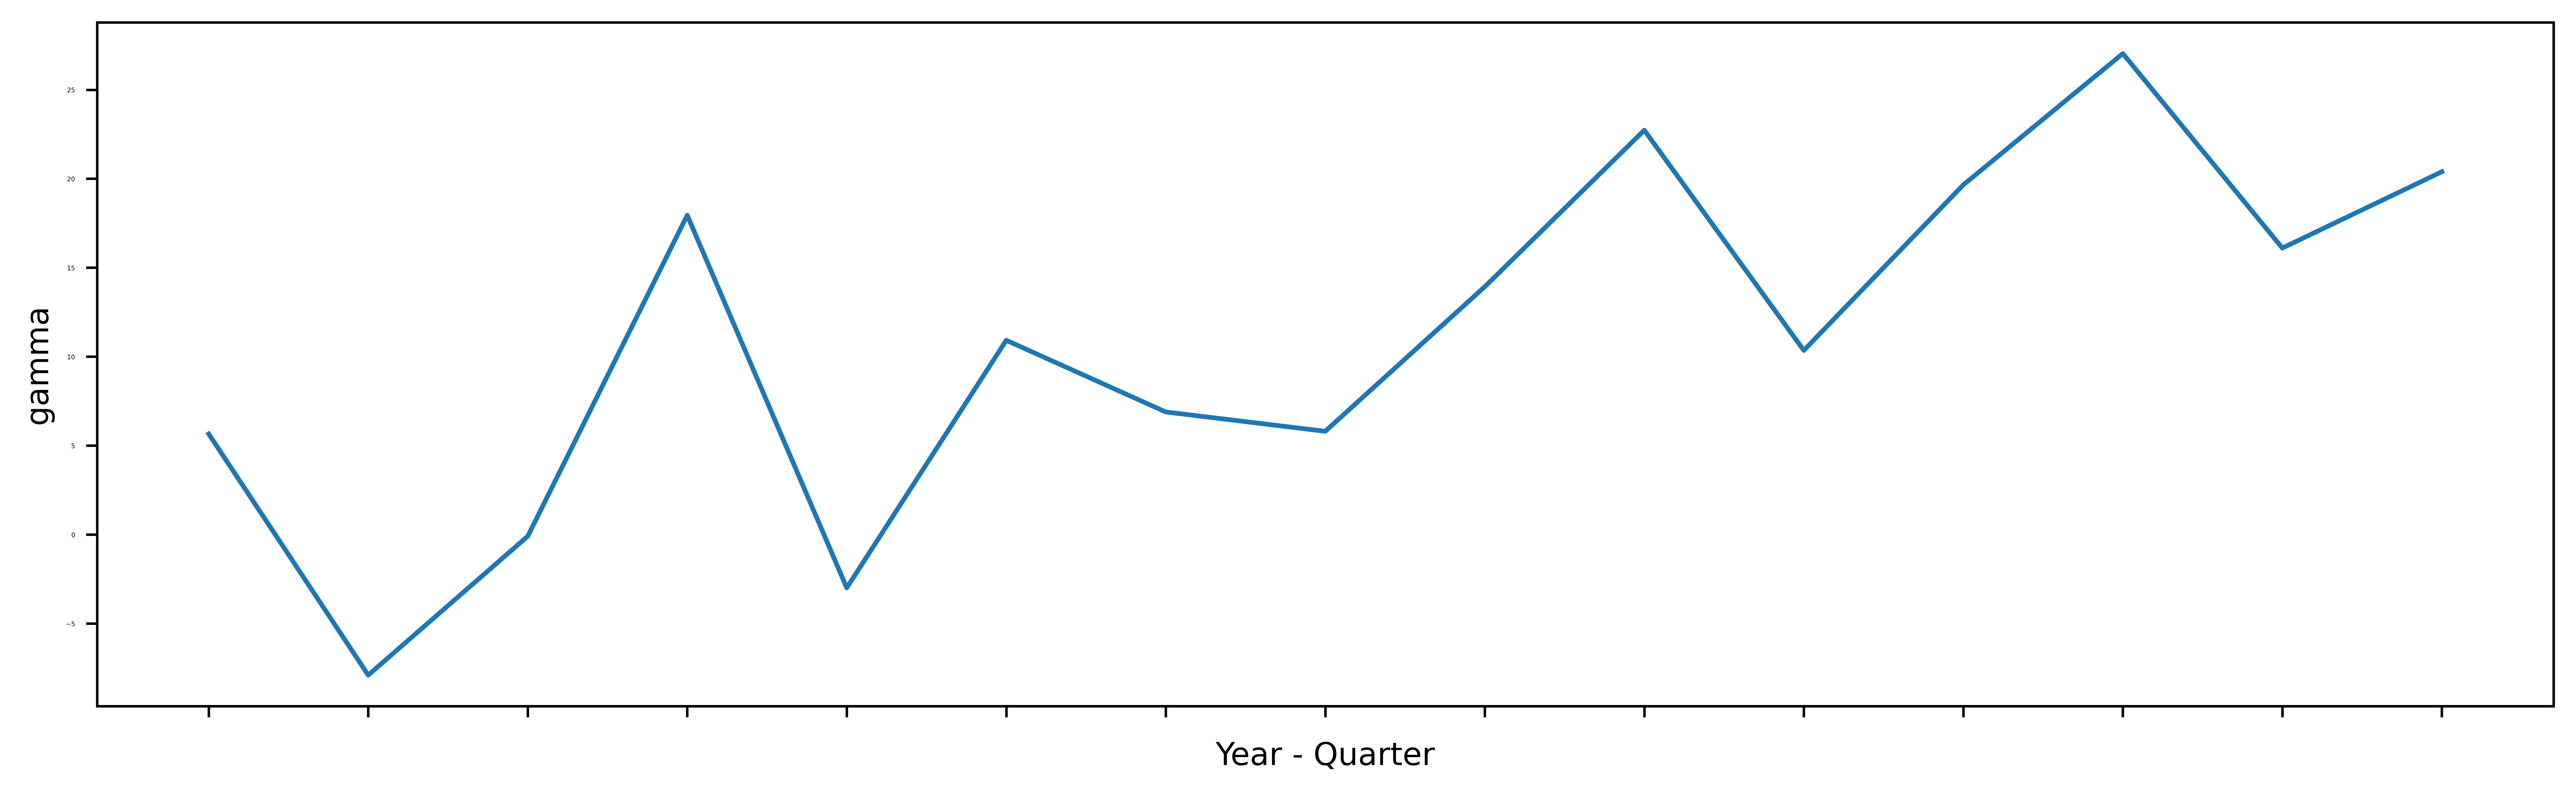

In [ ]:


fig, ax = plt.subplots(dpi=1000,figsize=(14, 4))
sns.lineplot(data = x, x = 'Year',y ='gamma')

#sns.barplot(x ='arrival_date_month', y = 'adults',hue = "is_canceled", data = d)
#sns.barplot(x ='arrival_date_month', y = 'is_canceled',hue = 'hotel', data = months_cancel , )

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.tick_params(axis='both', which='major', labelsize=2)
plt.xlabel('Year - Quarter', fontsize=10)
plt.show()

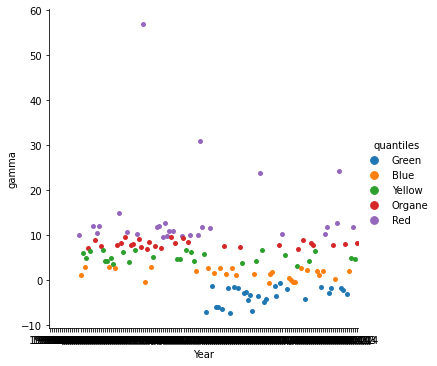

In [ ]:
sns.catplot(data = x, x = 'Year',y ='gamma',hue ='quantiles' )

## World Bank API 

In [ ]:
import pandas as pd
import world_bank_data as wb
pd.set_option('display.max_rows', 6)

In [ ]:
wb.get_topics()

value  \
id                                    
1   Agriculture & Rural Development   
2                 Aid Effectiveness   
3                  Economy & Growth   
4                         Education   
5                   Energy & Mining   
6                       Environment   
7                  Financial Sector   
8                            Health   
9                    Infrastructure   
10        Social Protection & Labor   
11                          Poverty   
12                   Private Sector   
13                    Public Sector   
14             Science & Technology   
15               Social Development   
16                Urban Development   
17                           Gender   
18      Millenium development goals   
19                   Climate Change   
20                    External Debt   
21                            Trade   

                                           sourceNote  
id                                                     
1   For the 70 percent of the world's poor who liv...  
2   Aid effectiveness is the impact that aid has i...  
3   Economic growth is central to economic develop...  
4   Education is one of the most powerful instrume...  
5   The world economy needs ever-increasing amount...  
6   Natural and man-made environmental resources –...  
7   An economy's financial markets are critical to...  
8   Improving health is central to the Millennium ...  
9   Infrastructure helps determine the success of ...  
10  The supply of labor available in an economy in...  
11  For countries with an active poverty monitorin...  
12  Private markets drive economic growth, tapping...  
13  Effective governments improve people's standar...  
14  Technological innovation, often fueled by gove...  
15  Data here cover child labor, gender issues, re...  
16  Cities can be tremendously efficient. It is ea...  
17  Gender equality is a core development objectiv...  
18                                                     
19  Climate change is expected to hit developing c...  
20  Debt statistics provide a detailed picture of ...  
21  Trade is a key means to fight poverty and achi...

In [ ]:
pd.DataFrame(wb.get_series('NY.GDP.MKTP.CD', date='1980:2020', id_or_value='id', simplify_index=True)).reset_index()

Country  Year  NY.GDP.MKTP.CD
0         AFE  1980    1.513985e+11
1         AFE  1981    1.577033e+11
2         AFE  1982    1.503731e+11
...       ...   ...             ...
10903     ZWE  2018    1.952362e+10
10904     ZWE  2019    1.693243e+10
10905     ZWE  2020    1.676851e+10

[10906 rows x 3 columns]

In [ ]:

'''
Annual Fields
M2_Multiplier_Growth = pd.DataFrame(wb.get_series('FM.LBL.BMNY.ZG', date='1980:2020', id_or_value='id', simplify_index=True)).reset_index()
M2_by_Reserves = pd.DataFrame(wb.get_series('FM.LBL.BMNY.IR.ZS', date='1980:2020', id_or_value='id', simplify_index=True)).reset_index()
REED = pd.DataFrame(wb.get_series('PX.REX.REER', date='1980:2020', id_or_value='id', simplify_index=True)).reset_index()
Fixed_Capital_Formation = pd.DataFrame(wb.get_series('NE.GDI.FTOT.CD', date='1980:2020', id_or_value='id', simplify_index=True)).reset_index()
Current Account = pd.DataFrame(wb.get_series('BN.CAB.XOKA.GD.ZS', date='1980:2020', id_or_value='id', simplify_index=True)).reset_index()


Quarterly Fields
DT.DOD.PUBS.ST.AR.US = Public Sector Ext. Debt Pos., Short-term, All instruments, USD
DT.DOD.DECT.CD.ST.US = Gross Ext. Debt Pos., All Sectors, Short-term, All instruments, USD
DP.DOD.DSTC.CR.GG.Z1 = Gross PSD, General Gov., Short-term, All instruments, Nominal Value, % of GDP #Quarterly Public Sector Debt



DT.DOD.DECT.CD.LT.US = Gross Ext. Debt Pos., All Sectors, Long-term, All instruments, USD
DP.DOD.DECN.CR.GG.Z1 = Gross PSD, General Gov., All maturities, All instruments, Domestic currency, Nominal Value, % of GDP #Quarterly Public Sector Debt

'''

Country  Year  FM.LBL.BMNY.ZG
0         ARB  1980             NaN
1         ARB  1981             NaN
2         ARB  1982             NaN
...       ...   ...             ...
10821     ZWE  2018       28.048464
10822     ZWE  2019      249.835278
10823     ZWE  2020             NaN

[10824 rows x 3 columns]

### Search Indicators

In [ ]:
wb.get_sources()

lastupdated                                      name code description url  \
id                                                                              
1   2019-10-23                            Doing Business  DBS                   
2   2021-06-30              World Development Indicators  WDI                   
3   2020-09-28           Worldwide Governance Indicators  WGI                   
5   2016-03-21         Subnational Malnutrition Database  SNM                   
6   2021-01-21             International Debt Statistics  IDS                   
..         ...                                       ...  ...         ...  ..   
81  2021-01-21       International Debt Statistics: DSSI  DSI                   
82  2021-03-24                 Global Public Procurement  GPP                   
83  2021-04-01  Statistical Performance Indicators (SPI)  SPI                   
84  2021-05-11                          Education Policy  EDP                   
85  2021-04-05                             PEFA_2021_SNG  SNG                   

   dataavailability metadataavailability concepts  
id                                                 
1                 Y                    Y        3  
2                 Y                    Y        3  
3                 Y                    Y        3  
5                 Y                    Y        3  
6                 Y                    Y        4  
..              ...                  ...      ...  
81                Y                    N        4  
82                Y                    N        3  
83                Y                    Y        3  
84                Y                    Y        3  
85                Y                    N        4  

[66 rows x 8 columns]

In [ ]:
#indicators = wb.get_indicators().reset_index()
import world_bank as wb

ModuleNotFoundError: No module named 'world_bank'

In [ ]:
indicators = wb.get_indicators().reset_index()
#indicators.head()
#indicators[(indicators['name'].str.contains('GDP'))&(indicators['source']=='World Development Indicators')]
#indicators[(indicators['id'].str.contains('NE.GDI.FTOT.CD'))&(indicators['source']=='World Development Indicators')]

#indicators[((indicators['name'].str.contains('government'))|(indicators['name'].str.contains('expenditure')))&(indicators['source']=='World Development Indicators')]

indicators[((indicators['name'].str.contains('government'))|(indicators['name'].str.contains('General')))&(indicators['source']=='World Development Indicators')]

NameError: name 'wb' is not defined

In [ ]:
wb.search_indicators('NY.GDP.MKTP.CD')

Empty DataFrame
Columns: [name, unit, source, sourceNote, sourceOrganization, topics]
Index: []

In [ ]:
srt[srt['id']=='NE.GDI.FTOT.CD']

id                                         name unit  \
1446  NE.GDI.FTOT.CD  Gross fixed capital formation (current US$)        

                            source  \
1446  World Development Indicators   

                                             sourceNote  \
1446  Gross fixed capital formation (formerly gross ...   

                                     sourceOrganization            topics  
1446  World Bank national accounts data, and OECD Na...  Economy & Growth

In [ ]:
srt = wb.search_indicators('formation').reset_index()
srt[srt['source'].isin([
                         'World Development Indicators'
#                        'Quarterly Public Sector Debt',
#                        'Quarterly External Debt Statistics SDDS',
#                        'Quarterly External Debt Statistics GDDS'#,  'World Development Indicators'  
                     ])]
#
#srt['source'].unique()



### Search Countries

In [ ]:
#wb.get_sources() #  All Database sources 
WB_countries = wb.get_countries().reset_index()


id iso2Code                                               name  \
0    ABW       AW                                              Aruba   
1    AFE                                 Africa Eastern and Southern   
2    AFG       AF                                        Afghanistan   
3    AFR       A9                                             Africa   
4    AFW                                  Africa Western and Central   
..   ...      ...                                                ...   
294  XZN       A5  Sub-Saharan Africa excluding South Africa and ...   
295  YEM       YE                                        Yemen, Rep.   
296  ZAF       ZA                                       South Africa   
297  ZMB       ZM                                             Zambia   
298  ZWE       ZW                                           Zimbabwe   

                         region  \
0    Latin America & Caribbean    
1                    Aggregates   
2                    South Asia   
3                    Aggregates   
4                    Aggregates   
..                          ...   
294                  Aggregates   
295  Middle East & North Africa   
296         Sub-Saharan Africa    
297         Sub-Saharan Africa    
298         Sub-Saharan Africa    

                                           adminregion          incomeLevel  \
0                                                               High income   
1                                                                Aggregates   
2                                           South Asia           Low income   
3                                                                Aggregates   
4                                                                Aggregates   
..                                                 ...                  ...   
294                                                              Aggregates   
295  Middle East & North Africa (excluding high inc...           Low income   
296         Sub-Saharan Africa (excluding high income)  Upper middle income   
297         Sub-Saharan Africa (excluding high income)  Lower middle income   
298         Sub-Saharan Africa (excluding high income)  Lower middle income   

        lendingType capitalCity  longitude  latitude  
0    Not classified  Oranjestad   -70.0167   12.5167  
1        Aggregates                    NaN       NaN  
2               IDA       Kabul    69.1761   34.5228  
3        Aggregates                    NaN       NaN  
4        Aggregates                    NaN       NaN  
..              ...         ...        ...       ...  
294      Aggregates                    NaN       NaN  
295             IDA      Sana'a    44.2075   15.3520  
296            IBRD    Pretoria    28.1871  -25.7460  
297             IDA      Lusaka    28.2937  -15.3982  
298           Blend      Harare    31.0672  -17.8312  

[299 rows x 10 columns]

In [ ]:
cntry = 'GB'
#WB_countries.query("iso2Code == 'GB'")
#wb.get_countries().reset_index()

C = WB_countries['id'][WB_countries['iso2Code']=='GB'].item()
print(C)

GBR


'''
'World Development Indicators'    
'Quarterly Public Sector Debt',
'Quarterly External Debt Statistics SDDS',
'Quarterly External Debt Statistics GDDS',
'''
UPP.COM.POL.XQ -Combined polity score

## IMF API

In [ ]:
l = ['A', 'B', 'c']
appended_data = []
for c in range(len(l)):
    print(f'Series_{c}')

Series_0
Series_1
Series_2


In [ ]:
Call_IMF('BOP',freq='Q',Country_iso2='MX', start='1980', finish='2020', Indicator_code='BCAXF_BP6_USD')

Year BCAXF_BP6_USD @OFFICIAL_BPM
0    1980-Q1         -1334           NaN
1    1980-Q2         -2552           NaN
2    1980-Q3         -3174           NaN
3    1980-Q4         -3362           NaN
4    1981-Q1         -2585           NaN
..       ...           ...           ...
159  2019-Q4   3197.165029           NaN
160  2020-Q1  -7526.547564           NaN
161  2020-Q2    -437.09415           NaN
162  2020-Q3  17125.341481           NaN
163  2020-Q4  17408.869761           NaN

[164 rows x 3 columns]

In [ ]:
import requests
import pandas as pd

# URL for the IMF JSON Restful Web Service, 
# IFS database, and Australian export prices series
url = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/IFS'

# Get data from the above URL using the requests package
XXX = requests.get(url).json()

# Load data into a pandas dataframe
XXX

'"Error":{"status":413,"message":"Response size exceeds service limit","more_info":"The query results in more than the supported maximum number of time series in one request. Please change your query. http://datahelp.imf.org/knowledgebase/articles/937155-how-to-query-large-datasets-with-data-services"}'

## Call example &amp; testing

In [ ]:
# Import libraries
import requests
import pandas as pd

# URL for the IMF JSON Restful Web Service, 
# IFS database, and Australian export prices series
url = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/IFS/M.AU.FILR_PA+RAXGFX_USD+TMG_CIF_USD+TXG_FOB_USD+PCPI_IX+35L___XDC+RAXG_USD+EREER_IX+32____XDC+FILR_PA+FIDR_PA.?startPeriod=1957&endPeriod=2016'
url2 = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/BOP/Q.AU.BFDLXF_BP6_USD.?startPeriod=1957&endPeriod=2016'
url3 = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/weo/A.AUS.GGX_NGDP.?startPeriod=1995&endPeriod=2016'
#cpi = 'http://dataservices.imf.org/REST/SDMX_XML.svc/CompactData/IFS/M..PCPI_IX.?startPeriod=2000&endPeriod=2001'
#Thiland = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/IFS/Q.TH.NX_SA_XDC.?startPeriod=1980&endPeriod=2020'
# Get data from the above URL using the requests package
BOP = requests.get(url2).json()
IFS = requests.get(url).json()
WEO = requests.get(url3).json()
# Load data into a pandas dataframe
#auxp = pd.DataFrame(data['CompactData']['DataSet']['Series']['Obs'])

# Show the last five observiations
#auxp.tail(100)

#BFXF_BP6_USD - works
#BCAXF_BP6_USD cURRENT ACCOUNT WORKS

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [ ]:
pd.DataFrame(IFS['CompactData']['DataSet']['Series'])

@FREQ @REF_AREA   @INDICATOR @UNIT_MULT @TIME_FORMAT  \
0     M        AU   RAXGFX_USD          6          P1M   
1     M        AU     EREER_IX          0          P1M   
2     M        AU     RAXG_USD          6          P1M   
3     M        AU  TMG_CIF_USD          6          P1M   
4     M        AU  TXG_FOB_USD          6          P1M   
5     M        AU    32____XDC          6          P1M   
6     M        AU    35L___XDC          6          P1M   
7     M        AU      FILR_PA          0          P1M   
8     M        AU      FIDR_PA          0          P1M   

                                                 Obs  
0  [{'@TIME_PERIOD': '1957-01', '@OBS_VALUE': '88...  
1  [{'@TIME_PERIOD': '1979-12', '@OBS_VALUE': '90...  
2  [{'@TIME_PERIOD': '1957-01', '@OBS_VALUE': '89...  
3  [{'@TIME_PERIOD': '1957-01', '@OBS_VALUE': '15...  
4  [{'@TIME_PERIOD': '1957-01', '@OBS_VALUE': '19...  
5  [{'@TIME_PERIOD': '1964-01', '@OBS_VALUE': '82...  
6  [{'@TIME_PERIOD': '1957-01', '@OBS_VALUE': '61...  
7  [{'@TIME_PERIOD': '1959-01', '@OBS_VALUE': '5'...  
8  [{'@TIME_PERIOD': '1981-12', '@OBS_VALUE': '13...

In [ ]:
(IFS['CompactData']['DataSet']['Series'][1]['@INDICATOR'])# gives the series neme 


'EREER_IX'

In [ ]:
float((IFS['CompactData']['DataSet']['Series'][1]['@UNIT_MULT'])) # gives the series neme 
#float(unit)

0.0

In [ ]:
pd.DataFrame(IFS['CompactData']['DataSet']['Series']).shape[0]

9

In [ ]:
pd.DataFrame(WEO['CompactData'])

@xmlns:xsi  \
ID         http://www.w3.org/2001/XMLSchema-instance   
Test       http://www.w3.org/2001/XMLSchema-instance   
Prepared   http://www.w3.org/2001/XMLSchema-instance   
Sender     http://www.w3.org/2001/XMLSchema-instance   
Receiver   http://www.w3.org/2001/XMLSchema-instance   
DataSetID  http://www.w3.org/2001/XMLSchema-instance   
@xmlns     http://www.w3.org/2001/XMLSchema-instance   
Series     http://www.w3.org/2001/XMLSchema-instance   

                                 @xmlns:xsd  \
ID         http://www.w3.org/2001/XMLSchema   
Test       http://www.w3.org/2001/XMLSchema   
Prepared   http://www.w3.org/2001/XMLSchema   
Sender     http://www.w3.org/2001/XMLSchema   
Receiver   http://www.w3.org/2001/XMLSchema   
DataSetID  http://www.w3.org/2001/XMLSchema   
@xmlns     http://www.w3.org/2001/XMLSchema   
Series     http://www.w3.org/2001/XMLSchema   

                                         @xsi:schemaLocation  \
ID         http://www.SDMX.org/resources/SDMXML/schemas/v...   
Test       http://www.SDMX.org/resources/SDMXML/schemas/v...   
Prepared   http://www.SDMX.org/resources/SDMXML/schemas/v...   
Sender     http://www.SDMX.org/resources/SDMXML/schemas/v...   
Receiver   http://www.SDMX.org/resources/SDMXML/schemas/v...   
DataSetID  http://www.SDMX.org/resources/SDMXML/schemas/v...   
@xmlns     http://www.SDMX.org/resources/SDMXML/schemas/v...   
Series     http://www.SDMX.org/resources/SDMXML/schemas/v...   

                                                      @xmlns  \
ID         http://www.SDMX.org/resources/SDMXML/schemas/v...   
Test       http://www.SDMX.org/resources/SDMXML/schemas/v...   
Prepared   http://www.SDMX.org/resources/SDMXML/schemas/v...   
Sender     http://www.SDMX.org/resources/SDMXML/schemas/v...   
Receiver   http://www.SDMX.org/resources/SDMXML/schemas/v...   
DataSetID  http://www.SDMX.org/resources/SDMXML/schemas/v...   
@xmlns     http://www.SDMX.org/resources/SDMXML/schemas/v...   
Series     http://www.SDMX.org/resources/SDMXML/schemas/v...   

                                                      Header  \
ID                      dd53059b-ccf9-4a9a-ac39-35ac61ac1a82   
Test                                                   false   
Prepared                                 2021-07-02T14:08:17   
Sender     {'@id': '1C0', 'Name': {'@xml:lang': 'en', '#t...   
Receiver                                      {'@id': 'ZZZ'}   
DataSetID                                                BOP   
@xmlns                                                   NaN   
Series                                                   NaN   

                                                     DataSet  
ID                                                       NaN  
Test                                                     NaN  
Prepared                                                 NaN  
Sender                                                   NaN  
Receiver                                                 NaN  
DataSetID                                                NaN  
@xmlns               http://dataservices.imf.org/compact/BOP  
Series     {'@FREQ': 'A', '@REF_AREA': 'AU', '@INDICATOR'...

In [ ]:
# Import libraries
import requests
url = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/'
key = 'CompactData/IFS/M.GB+UK.PMP_IX' # adjust codes here

# Navigate to series in API-returned JSON data
data = requests.get(f'{url}{key}').json()['CompactData']['DataSet']['Series']

print(data['Obs'])

SyntaxError: invalid syntax (<ipython-input-39-31cd623e8f63>, line 7)

# Focused Emerging Markets 

Countries inspected 

Argentine, Brazil, Chile, Colombia, Mexico, Peru, Venezuela (No Data), Czech rep., Egypt, Hungary, Israel, Poland, Romania, Russia, South Africa, Turkey, Ukraine. India, Indonesia, Korea, Malaysia, Philippines, Thailand 

In [ ]:
EM_iso2 = ['AR','BR','CL','MX','CO','CZ', 'EG','HU','IL', 'PL','RO','RU','ZA','TR','UA','IN', 'KR', 'MY','PH','TH'] # 

In [ ]:
WB_countries = wb.get_countries().reset_index()

In [ ]:
#WB_countries.query("iso2Code == 'GB'")
#wb.get_countries().reset_index()
WB_countries[WB_countries['name'].str.contains('Mexico')] 
#C = WB_countries['id'][WB_countries['iso2Code']=='GB'].item()

id iso2Code    name                      region  \
180  MEX       MX  Mexico  Latin America & Caribbean    

                                           adminregion          incomeLevel  \
180  Latin America & Caribbean (excluding high income)  Upper middle income   

    lendingType  capitalCity  longitude  latitude  
180        IBRD  Mexico City   -99.1276    19.427

In [ ]:
test_iso = ['AR','BR', 'MX']
Multi_Call_IMF('IFS','Q',test_iso, 2018, 2020, 'FIMM_PA')

Year    FIMM_PA Country
0   2018-Q1  26.966667      AR
1   2018-Q2  34.923333      AR
2   2018-Q3  51.006667      AR
3   2018-Q4  63.783333      AR
4   2019-Q1  52.230000      AR
5   2019-Q2  67.490000      AR
6   2019-Q3  65.203333      AR
7   2019-Q4  55.223333      AR
8   2020-Q1  34.806667      AR
9   2020-Q2  12.776667      AR
10  2020-Q3  15.626667      AR
11  2020-Q4  26.893333      AR
0   2018-Q1   6.732632      BR
1   2018-Q2   6.400000      BR
2   2018-Q3   6.400000      BR
3   2018-Q4   6.400000      BR
4   2019-Q1   6.400000      BR
5   2019-Q2   6.400000      BR
6   2019-Q3   6.003333      BR
7   2019-Q4   4.956667      BR
8   2020-Q1   4.180000      BR
9   2020-Q2   3.080000      BR
10  2020-Q3   1.996667      BR
11  2020-Q4   1.900000      BR
0   2018-Q1   7.750000      MX
1   2018-Q2   7.873333      MX
2   2018-Q3   8.106667      MX
3   2018-Q4   8.260000      MX
4   2019-Q1   8.556667      MX
5   2019-Q2   8.506667      MX
6   2019-Q3   8.350000      MX
7   2019-Q4   7.856667      MX
8   2020-Q1   7.340000      MX
9   2020-Q2   6.063333      MX
10  2020-Q3   4.973333      MX
11  2020-Q4   4.506667      MX

In [ ]:
WB_countries = wb.get_countries().reset_index()
EM_regions = WB_countries[WB_countries['iso2Code'].isin(test)]
EM_regions = EM_regions[['iso2Code', 'region']]
EM_regions.rename(columns={'iso2Code':'Country'}, inplace=True)
EM_regions

Country                      region
10       AR  Latin America & Caribbean 
35       BR  Latin America & Caribbean 
49       CL  Latin America & Caribbean 
57       CO  Latin America & Caribbean 
67       CZ       Europe & Central Asia
90       EG  Middle East & North Africa
125      HU       Europe & Central Asia
134      IN                  South Asia
140      IL  Middle East & North Africa
151      KR         East Asia & Pacific
180      MX  Latin America & Caribbean 
195      MY         East Asia & Pacific
216      PH         East Asia & Pacific
219      PL       Europe & Central Asia
230      RO       Europe & Central Asia
232      RU       Europe & Central Asia
264      TH         East Asia & Pacific
275      TR       Europe & Central Asia
296      ZA         Sub-Saharan Africa

In [ ]:
#test_isoEM_iso2
EM_iso2 = ['AR','BR','CL','CO','MX','CO','CZ', 'EG','HU','IL', 'PL','RO','RU','ZA','TR','UA','IN', 'KR', 'MY','PH','TH'] #UA - no data 

test_central = ['AR','BR','CL','MX','CO','CZ','EG','HU','IL', 'PL','RO','RU','ZA','TR','IN', 'KR', 'MY','PH','TH']
EM_central_1980_2020 = multi_crash(test_central,'1980', '2020', term='central', frequency ='M')

In [ ]:
test_mmk = ['AR','BR','CL','MX','CO','CZ', 'PL','RO','RU','ZA','IN','KR','MY','PH','TH'] # No data for :'EG','HU','TR'
#TR, IL, EG, HU- Central

EM_MMK_1980_2020 = multi_crash(test_mmk,'1980', '2020', term='MMK', frequency ='M')
#EM_MMK_1980_2020[EM_MMK_1980_2020['Country']=='AR'].sort_values(by='Year')

In [ ]:
EM_MMK_1980_2020

Year Country    FIMM_PA  ENDA_XDC_USD_RATE  \
0     1980-01      BR  41.747762       1.888667e-11   
1     1980-02      BR  34.017291       1.941419e-11   
2     1980-03      BR  52.337812       2.012997e-11   
3     1980-04      BR  26.080163       2.091239e-11   
4     1980-05      BR  27.272519       2.154680e-11   
...       ...     ...        ...                ...   
7058  1994-10      CO        NaN       8.395417e+02   
7059  1994-11      CO        NaN       8.300250e+02   
7060  1994-12      CO        NaN       8.293436e+02   
7061  1995-01      CO        NaN       8.466729e+02   
7062  1995-02      CO        NaN       8.505701e+02   

      USA - Money Market Rate - FIMM_PA    % Diff  Dom_rate  US_rate  \
0                                 13.82       NaN  1.417478   1.1382   
1                                 14.13       NaN  1.340173   1.1413   
2                                 17.19       NaN  1.523378   1.1719   
3                                 17.61       NaN  1.260802   1.1761   
4                                 10.98       NaN  1.272725   1.1098   
...                                 ...       ...       ...      ...   
7058                               4.76 -0.061467       NaN   1.0476   
7059                               5.29 -0.077125       NaN   1.0529   
7060                               5.45 -0.091504       NaN   1.0545   
7061                               5.53 -0.080903       NaN   1.0553   
7062                               5.92 -0.085143       NaN   1.0592   

      rate ratio  gamma Defined_cut                      region  
0       1.245368    NaN         NaN  Latin America & Caribbean   
1       1.174251    NaN         NaN  Latin America & Caribbean   
2       1.299922    NaN         NaN  Latin America & Caribbean   
3       1.072019    NaN         NaN  Latin America & Caribbean   
4       1.146806    NaN         NaN  Latin America & Caribbean   
...          ...    ...         ...                         ...  
7058         NaN    NaN         NaN  Latin America & Caribbean   
7059         NaN    NaN         NaN  Latin America & Caribbean   
7060         NaN    NaN         NaN  Latin America & Caribbean   
7061         NaN    NaN         NaN  Latin America & Caribbean   
7062         NaN    NaN         NaN  Latin America & Caribbean   

[7063 rows x 12 columns]

In [ ]:
EM_central_1980_2020.to_csv(r'EM_central_1980_2020.csv',sep=',', index=False, header = True)
EM_MMK_1980_2020.to_csv(r'EM_MMK_1980_2020.csv',sep=',', index=False, header = True)

### Data Availability for EM (using M-Mkts rate)

In [ ]:
#EM_MMK_1980_2020[EM_MMK_1980_2020['region'].str.contains('Latin America & Caribbean')]
#EM_MMK_1980_2020.dropna(how='any',axis=0).groupby(['Country']).agg({'Year':'min'}).reset_index()
# Period 12
describe_EM_MMK = EM_MMK_1980_2020.dropna(how='any',axis=0).groupby(['Country']).agg(Minimum_Date=('Year', np.min),
                                                                    Maximum_Date=('Year', np.max),
                                                                    Mean_gamma =('gamma',np.mean ),
                                                                    std_dev_gamma =('gamma',np.std )).reset_index()
  
describe_EM_MMK

Country Minimum_Date Maximum_Date  Mean_gamma  std_dev_gamma
0       AR      2011-01      2020-12   48.666399      44.941237
1       BR      1981-01      2020-12   97.599429     216.579130
2       CL      2000-12      2020-12    2.725121      11.866453
3       CO      1996-03      2020-12    7.405221      15.937687
4       CZ      1994-01      2020-12   -0.109192      11.869513
5       IN      1981-01      2020-12    8.143249      10.851783
6       KR      1981-01      2020-12    2.692732      14.824324
7       MX      1982-04      2020-12   37.491550      74.884463
8       MY      1981-01      2020-12    2.101340      10.191462
9       PH      1981-01      2020-12    6.170025      15.370374
10      PL      1991-12      2020-12    6.668600      16.750354
11      RO      1996-01      2020-12   25.813596      57.121473
12      RU      1996-06      2020-12   20.857371      62.075222
13      TH      1990-01      2020-12    1.507965      14.015679
14      ZA      1981-01      2020-12    9.954024      18.237277

In [ ]:
#EM_MMK_1980_2020[EM_MMK_1980_2020['region'].str.contains('Latin America & Caribbean')]
#EM_MMK_1980_2020.dropna(how='any',axis=0).groupby(['Country']).agg({'Year':'min'}).reset_index()
# period 3
describe_cent = EM_central_1980_2020.dropna(how='any',axis=0).groupby(['Country']).agg(Minimum_Date=('Year', np.min),
                                                                    Maximum_Date=('Year', np.max),
                                                                    Mean_gamma =('gamma',np.mean ),
                                                                    std_dev_gamma =('gamma',np.std )).reset_index()
  
describe_cent

Country Minimum_Date Maximum_Date  Mean_gamma  std_dev_gamma
0       AR      2002-04      2020-12    8.187066      20.043111
1       BR      1999-07      2020-12    1.869144      10.060593
2       CL      1995-08      2020-12    0.864233       5.435227
3       CO      1995-07      2020-12    1.837503       7.100892
4       CZ      1996-03      2020-12    0.005743       6.084107
5       EG      2013-12      2020-12    6.581152      24.317797
6       HU      1985-04      2020-12    1.581627       6.301023
7       IL      1995-04      2020-12    0.192313       3.773369
8       IN      2008-12      2017-07    1.931798       4.688659
9       KR      1999-08      2020-12    0.053166       5.035360
10      MX      2002-03      2020-12    1.317834       6.312225
11      MY      2002-03      2020-12    0.172579       3.453116
12      PH      2002-03      2020-12   -0.041373       2.849348
13      PL      1998-04      2020-12    0.319993       7.002006
14      RO      1994-03      2020-12    5.081706      14.771302
15      RU      2002-03      2020-12    1.760368       9.963127
16      TH      2000-08      2020-12   -0.264883       3.036622
17      TR      1986-07      2020-12   12.828779      30.898703
18      ZA      1998-06      2020-12    1.686539       8.949162

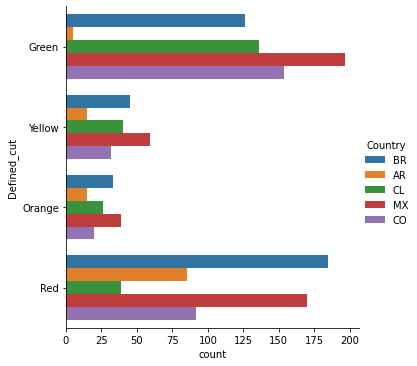

In [ ]:
sns.catplot(kind = 'count',
            data = EM_MMK_1980_2020[EM_MMK_1980_2020['region'].str.contains('Latin America & Caribbean')],
             y ='Defined_cut',
             hue ='Country' )

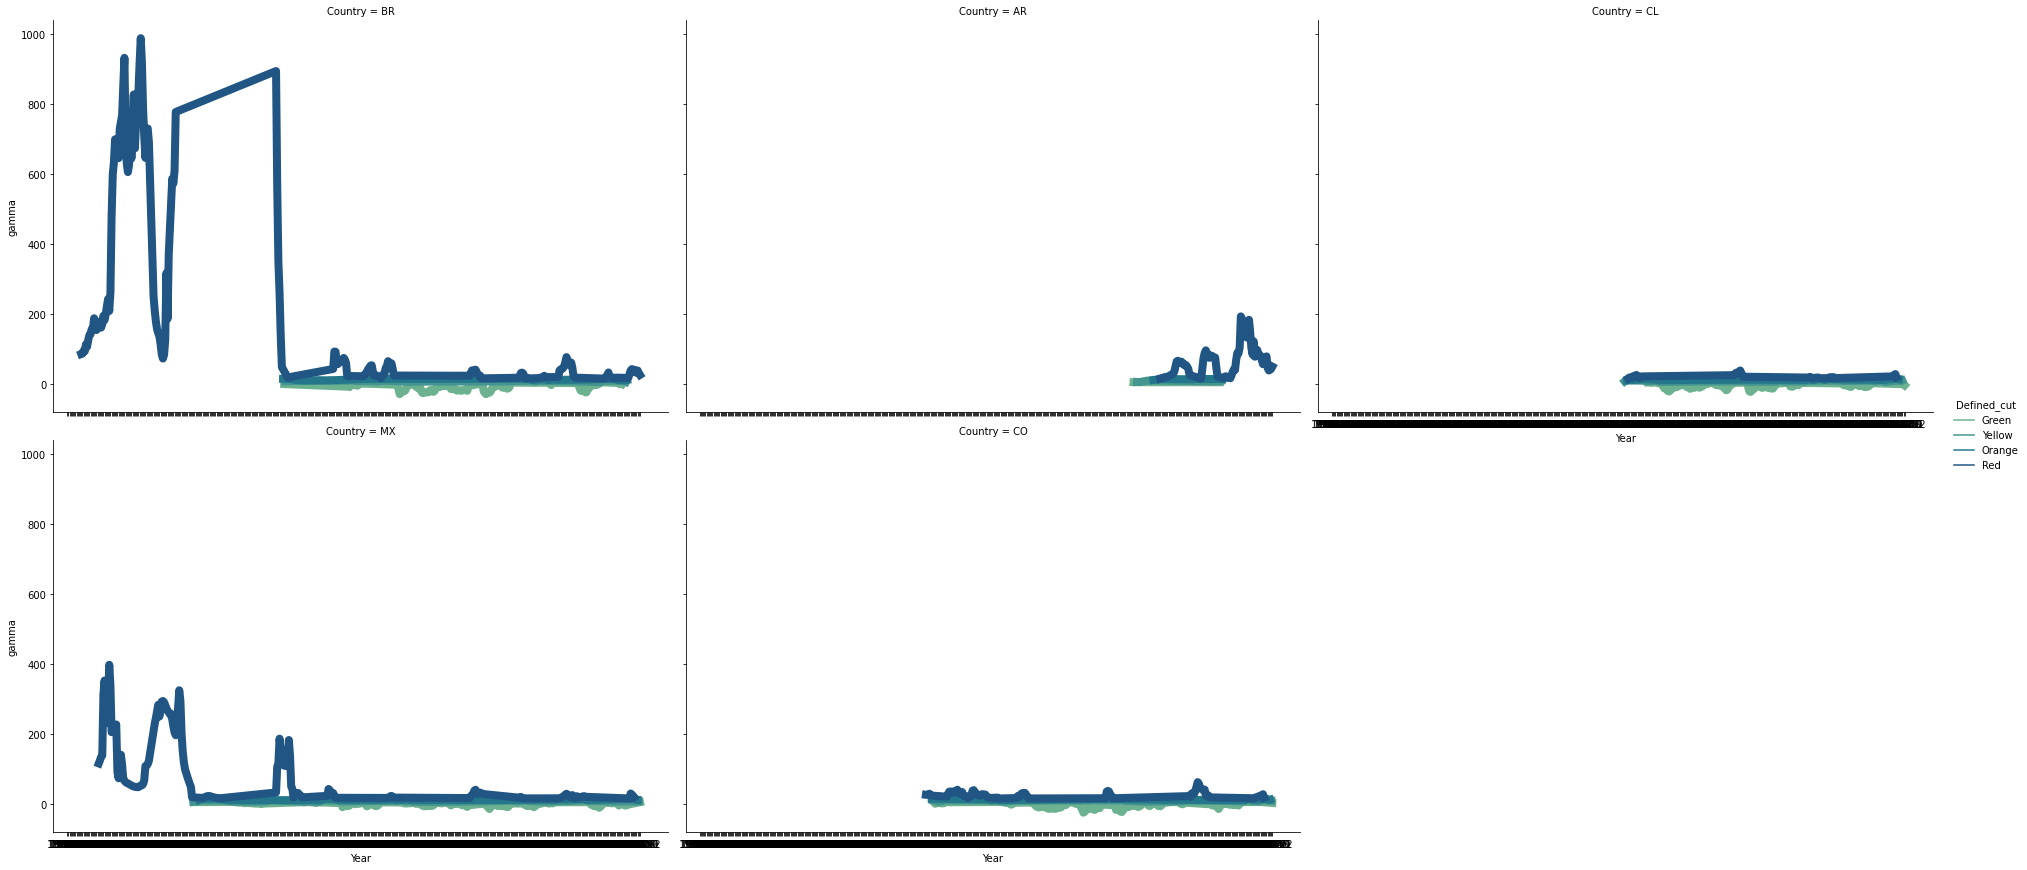

In [ ]:
sns.relplot(
    data= EM_MMK_1980_2020[EM_MMK_1980_2020['region'].str.contains('Latin America & Caribbean')],
    x="Year", y="gamma", col="Country", hue="Defined_cut",
    kind="line", palette="crest", linewidth=8, zorder=5,
    col_wrap=3, height=6, aspect=1.5, legend=True,
)

In [ ]:
def plot_crash_and_rates(full_data):
    full_data['Date'] = pd.to_datetime(full_data.Year)

    full_data.sort_values(by=['Date','Country'])
    cntry = full_data.Country.unique().tolist()



    fig, ax = plt.subplots(nrows = len(cntry), ncols = 2, figsize=(20,20))

    for i in range(len(cntry)):
        
        data = full_data[full_data.Country ==cntry[i]].copy()
        data.dropna(subset=['gamma'], inplace = True, axis=0)
        #data.dropna(how='any',axis=0)
        data.sort_values(by=['Date','Country'])
        x = data.Date
        y1 = data.gamma

        ax[i,0].plot(x, y1)
        ax[i,0].set_title(f'{cntry[i]} - Crash classification time series')
        ax[i,0].set_ylabel('Gamma(%\n Crash Indicator')
        ax[i,0].set_xlabel('Time (Month end time increments) ')
        ax[i,0].fill_between(x,y1,  color='#02d102', alpha = 0.3)
        ax[i,0].fill_between(x,y1, where=(5 < data.gamma), color='#ffff63', alpha = 0.3)
        ax[i,0].fill_between(x,y1, where=(10 < data.gamma), color='#ff8d23', alpha = 0.3)
        ax[i,0].fill_between(x,y1, where=(15 < data.gamma), color='#ff00ff', alpha = 0.3)
        custom_lines = [Line2D([0],[0],color='#02d102', alpha = 0.3),
                        Line2D([0], [0], color='#ffff63', alpha = 0.3),
                        Line2D([0],[0],color='#ff8d23', alpha = 0.3),
                        Line2D([0], [0], color='#ff00ff', alpha = 0.3)]
        ax[i,0].legend(custom_lines,['<5%', '5%<gamma', '10%<gamma','15%<gamma'])

        ax[i,1].plot(x, data.iloc[:,2]) #Domestice Short term rate
        ax[i,1].plot(x, data.iloc[:,4]) #US Short term rate
        ax[i,1].set_title(f'US vs {cntry[i]} Short Term Policy Rates')
        ax[i,1].set_ylabel('Policy Rate (%)')
        ax[i,1].set_xlabel('Time')
        ax[i,1].legend([f'{cntry[i]} M-Mkt Rate', 'US M-Mkt Rate'], loc = 'upper center')
        ax0 = ax[i,1].twinx()
        ax0.plot(x, data.iloc[:,3],color='#ff0000',linestyle = '--' ) #FX Rate 
        ax0.set_ylabel(f'{cntry[i]} Domestic Currency per 1 US Dollar ')
        ax0.legend(['FX Rate to USD'], loc = 'upper right')
    fig.tight_layout()



In [ ]:
def plot_crash_comparisons(full_data):
    full_data['Date'] = pd.to_datetime(full_data.Year)

    full_data.sort_values(by=['Date','Country'])
    cntry = full_data.Country.unique().tolist()



    fig, ax = plt.subplots(nrows = len(cntry), ncols = 3, figsize=(20,20))

    for i in range(len(cntry)):
        
        data = full_data[full_data.Country ==cntry[i]].copy()
        data.dropna(subset=['gamma'], inplace = True, axis=0)
        #data.dropna(how='any',axis=0)
        data.sort_values(by=['Date','Country'])
        x = data.Date
        y1 = data.gamma.copy()

        ax[i,0].plot(x, y1)
        ax[i,0].set_title(f'{cntry[i]} - Crash classification time series')
        ax[i,0].set_ylabel('Gamma(%\n Crash Indicator')
        ax[i,0].set_xlabel('Time (Month end time increments) ')
        ax[i,0].fill_between(x,y1,  color='#02d102', alpha = 0.3)
        ax[i,0].fill_between(x,y1, where=(5 < data.gamma), color='#ffff63', alpha = 0.3)
        ax[i,0].fill_between(x,y1, where=(10 < data.gamma), color='#ff8d23', alpha = 0.3)
        ax[i,0].fill_between(x,y1, where=(15 < data.gamma), color='#ff00ff', alpha = 0.3)
        custom_lines = [Line2D([0],[0],color='#02d102', alpha = 0.3),
                        Line2D([0], [0], color='#ffff63', alpha = 0.3),
                        Line2D([0],[0],color='#ff8d23', alpha = 0.3),
                        Line2D([0], [0], color='#ff00ff', alpha = 0.3)]
        ax[i,0].legend(custom_lines,['<5%', '5%<gamma', '10%<gamma','15%<gamma'])

        y2 = 100*data.iloc[:,[3]].pct_change(periods = 3).copy()
        


        ax[i,1].plot(x, y2) #3 Month Percentage Chage 
        ax[i,1].plot([x.min(), x.max()], [5, 5],color='#ffff63',linestyle = '--' , alpha = 0.1, linewidth= 0.5) #5%
        ax[i,1].plot([x.min(), x.max()], [10, 10],color='#ff8d23',linestyle = '--' , alpha = 0.1, linewidth= 0.5) #10%
        ax[i,1].plot([x.min(), x.max()], [15, 15],color='#ff00ff',linestyle = '--' , alpha = 0.1, linewidth= 0.5) #15%


        ax[i,1].set_title(f'US vs {cntry[i]} Short Term Policy Rates')
        ax[i,1].set_ylabel('FX Rate Change (%)')
        ax[i,1].set_xlabel('Time')
        ax[i,1].legend([f'3-mth FX Change'], loc = 'upper center')
        #ax[i,1].fill_between(x,y2,  color='#02d102', alpha = 0.3)
        #ax[i,1].fill_between(x,y2, where=(5 < y2), color='#ffff63', alpha = 0.3)
        #ax[i,1].fill_between(x,y2, where=(10 <y2), color='#ff8d23', alpha = 0.3)
        #ax[i,1].fill_between(x,y2, where=(15 <y2), color='#ff00ff', alpha = 0.3)
        #custom_lines = [Line2D([0],[0],color='#02d102', alpha = 0.3),
        #                Line2D([0], [0], color='#ffff63', alpha = 0.3),
        #                Line2D([0],[0],color='#ff8d23', alpha = 0.3),
        #                Line2D([0], [0], color='#ff00ff', alpha = 0.3)]
        ax1 = ax[i,1].twinx()
        ax1.plot(x, data.iloc[:,3],color='#ff0000',linestyle = '--' ) #FX Rate 
        ax1.set_ylabel(f'{cntry[i]} Domestic Currency per 1 US Dollar ')
        ax1.legend(['FX Rate to USD'], loc = 'upper right')

        y3=100*data.iloc[:,[3]].pct_change(periods = 6).copy()
        ax[i,2].plot(x, y3) #6 Month Percentage Chage 
        ax[i,2].set_title(f'US vs {cntry[i]} Short Term Policy Rates')
        ax[i,2].set_ylabel('FX Rate Change (%)')
        ax[i,2].set_xlabel('Time')
        ax[i,2].legend([f'6-mth FX Change'], loc = 'upper center')
        ax[i,2].plot([x.min(), x.max()], [5, 5],color='#ffff63',linestyle = '--' , alpha = 0.1, linewidth= 0.5) #5%
        ax[i,2].plot([x.min(), x.max()], [10, 10],color='#ff8d23',linestyle = '--' , alpha = 0.1, linewidth= 0.5) #10%
        ax[i,2].plot([x.min(), x.max()], [15, 15],color='#ff00ff',linestyle = '--' , alpha = 0.1, linewidth= 0.5) #15%        
        #ax[i,2].fill_between(x,y3,  color='#02d102', alpha = 0.3)
        #ax[i,2].fill_between(x,y3, where=(5 <  y3), color='#ffff63', alpha = 0.3)
        #ax[i,2].fill_between(x,y3, where=(10 < y3), color='#ff8d23', alpha = 0.3)
        #ax[i,2].fill_between(x,y3, where=(15 < y3), color='#ff00ff', alpha = 0.3)
        #custom_lines = [Line2D([0],[0],color='#02d102', alpha = 0.3),
        #                Line2D([0], [0], color='#ffff63', alpha = 0.3),
        #                Line2D([0],[0],color='#ff8d23', alpha = 0.3),
        #                Line2D([0], [0], color='#ff00ff', alpha = 0.3)]
        ax2 = ax[i,2].twinx()
        ax2.plot(x, data.iloc[:,3],color='#ff0000',linestyle = '--' ) #FX Rate 
        ax2.set_ylabel(f'{cntry[i]} Domestic Currency per 1 US Dollar ')
        ax2.legend(['FX Rate to USD'], loc = 'upper right')
    fig.tight_layout()



/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


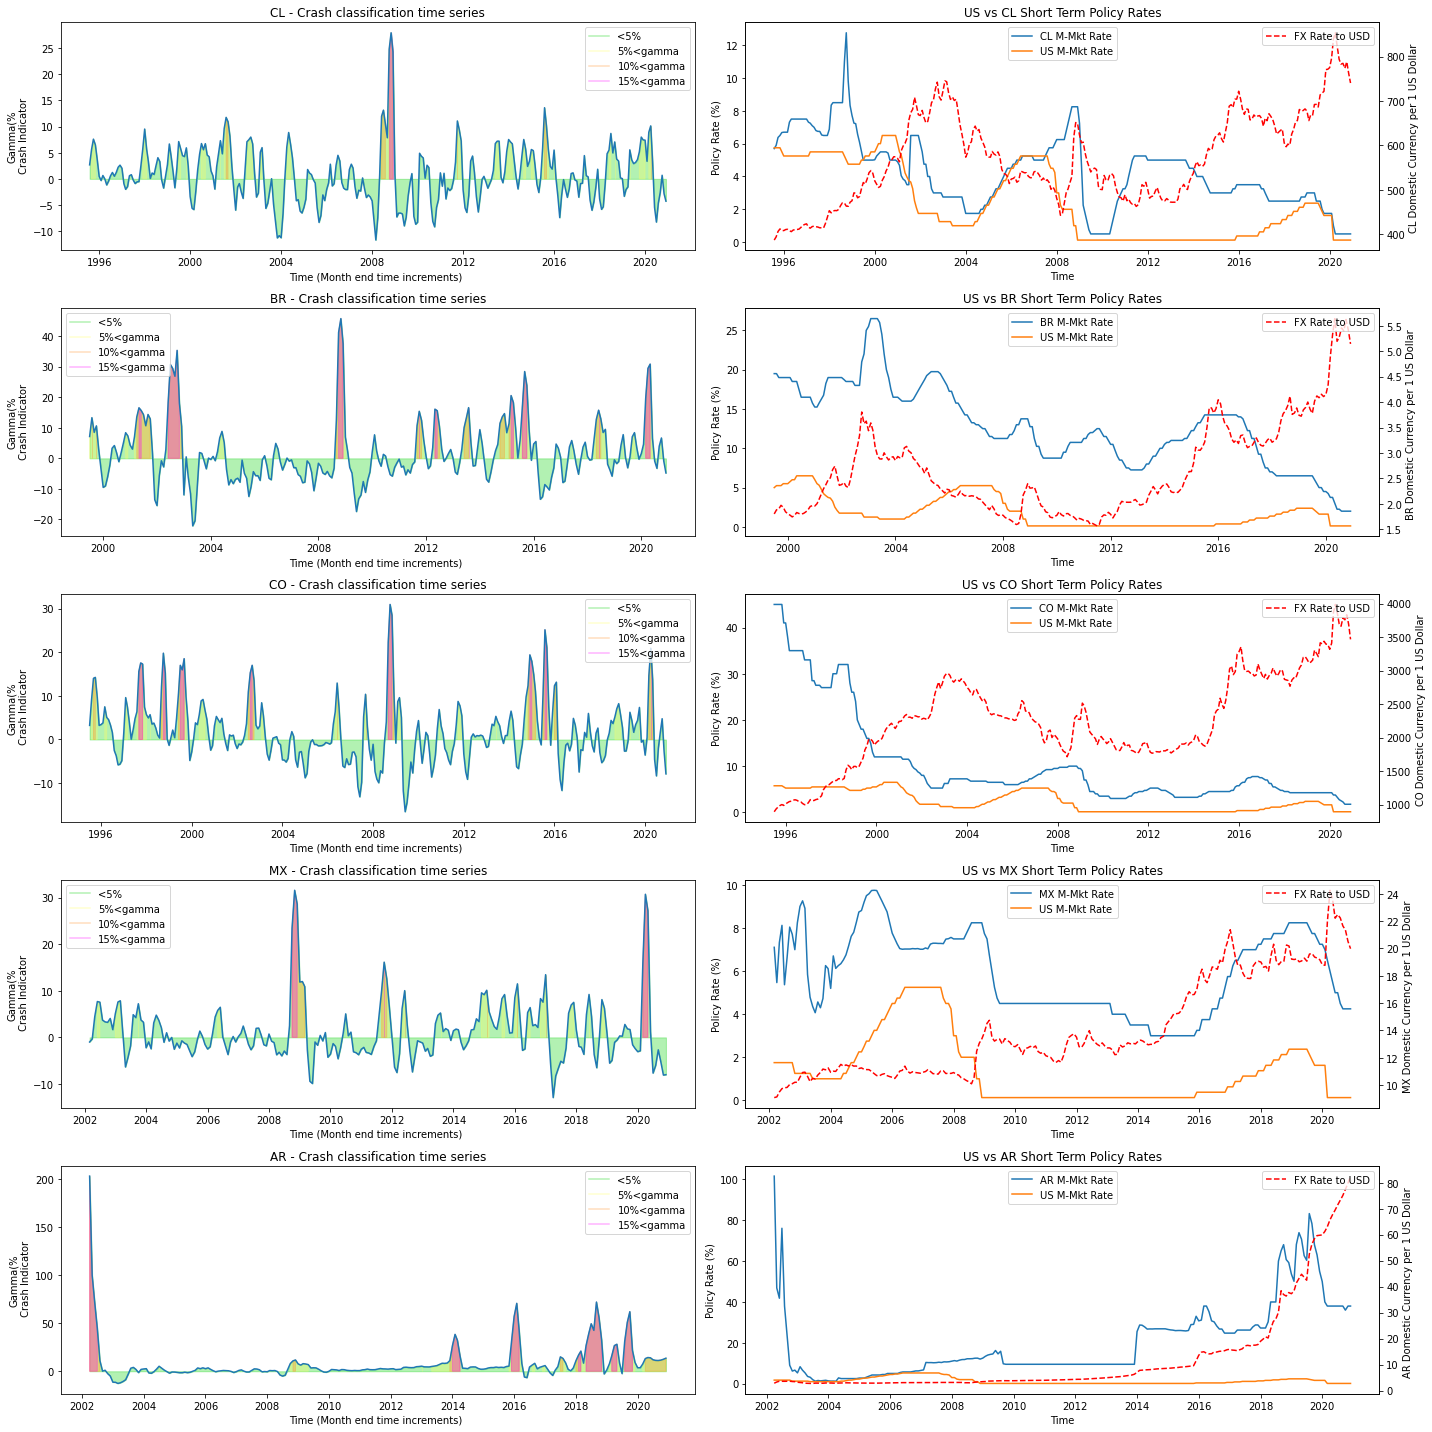

In [ ]:

#LATM = EM_MMK_1980_2020[EM_MMK_1980_2020['region'].str.contains('Latin America & Caribbean')]
LATM =EM_central_1980_2020[EM_central_1980_2020['region'].str.contains('Latin America & Caribbean')]
plot_crash_and_rates(LATM)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


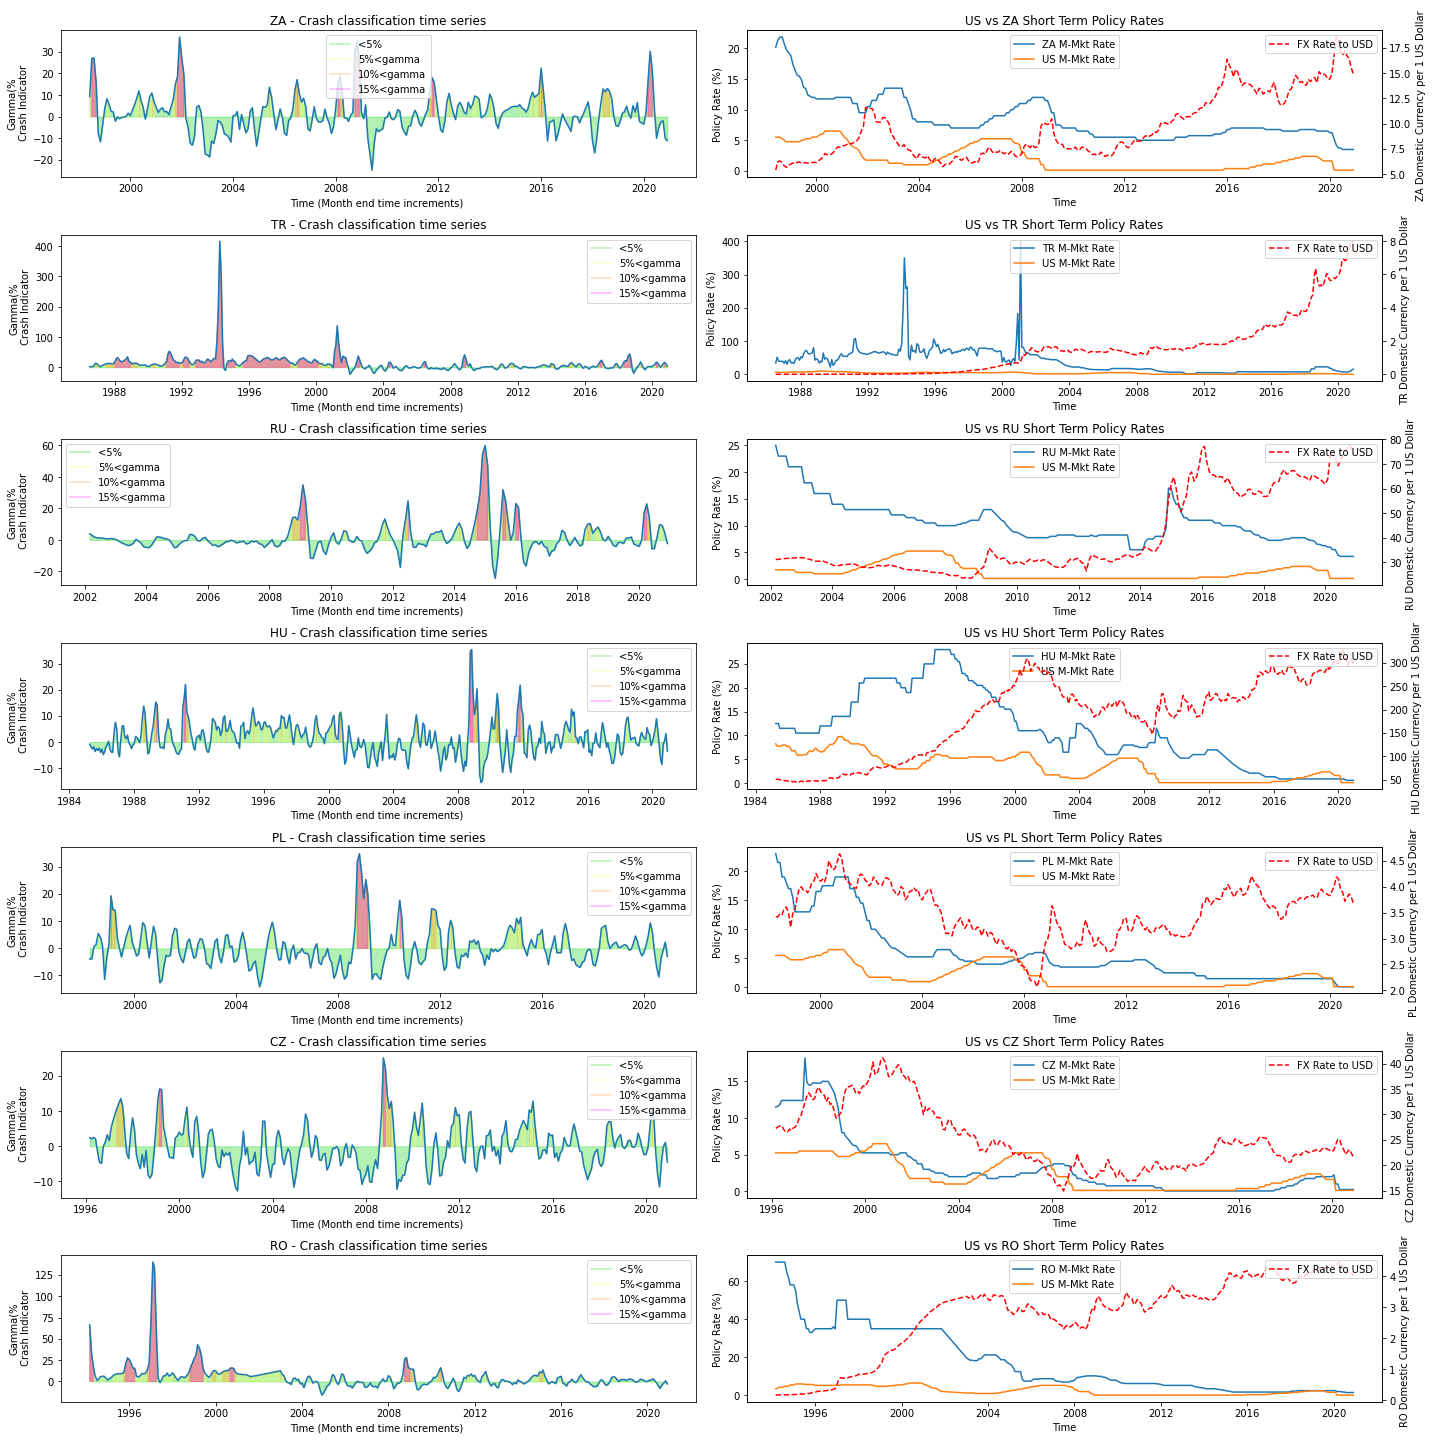

In [ ]:
#Europe & Central Asia
#EMEA = EM_MMK_1980_2020[EM_MMK_1980_2020['region'].str.contains('Europe & Central Asia')|EM_MMK_1980_2020['region'].str.contains('Sub-Saharan Africa ')]
EMEA = EM_central_1980_2020[EM_central_1980_2020['region'].str.contains('Europe & Central Asia')|EM_central_1980_2020['region'].str.contains('Sub-Saharan Africa ')]
plot_crash_and_rates(EMEA)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


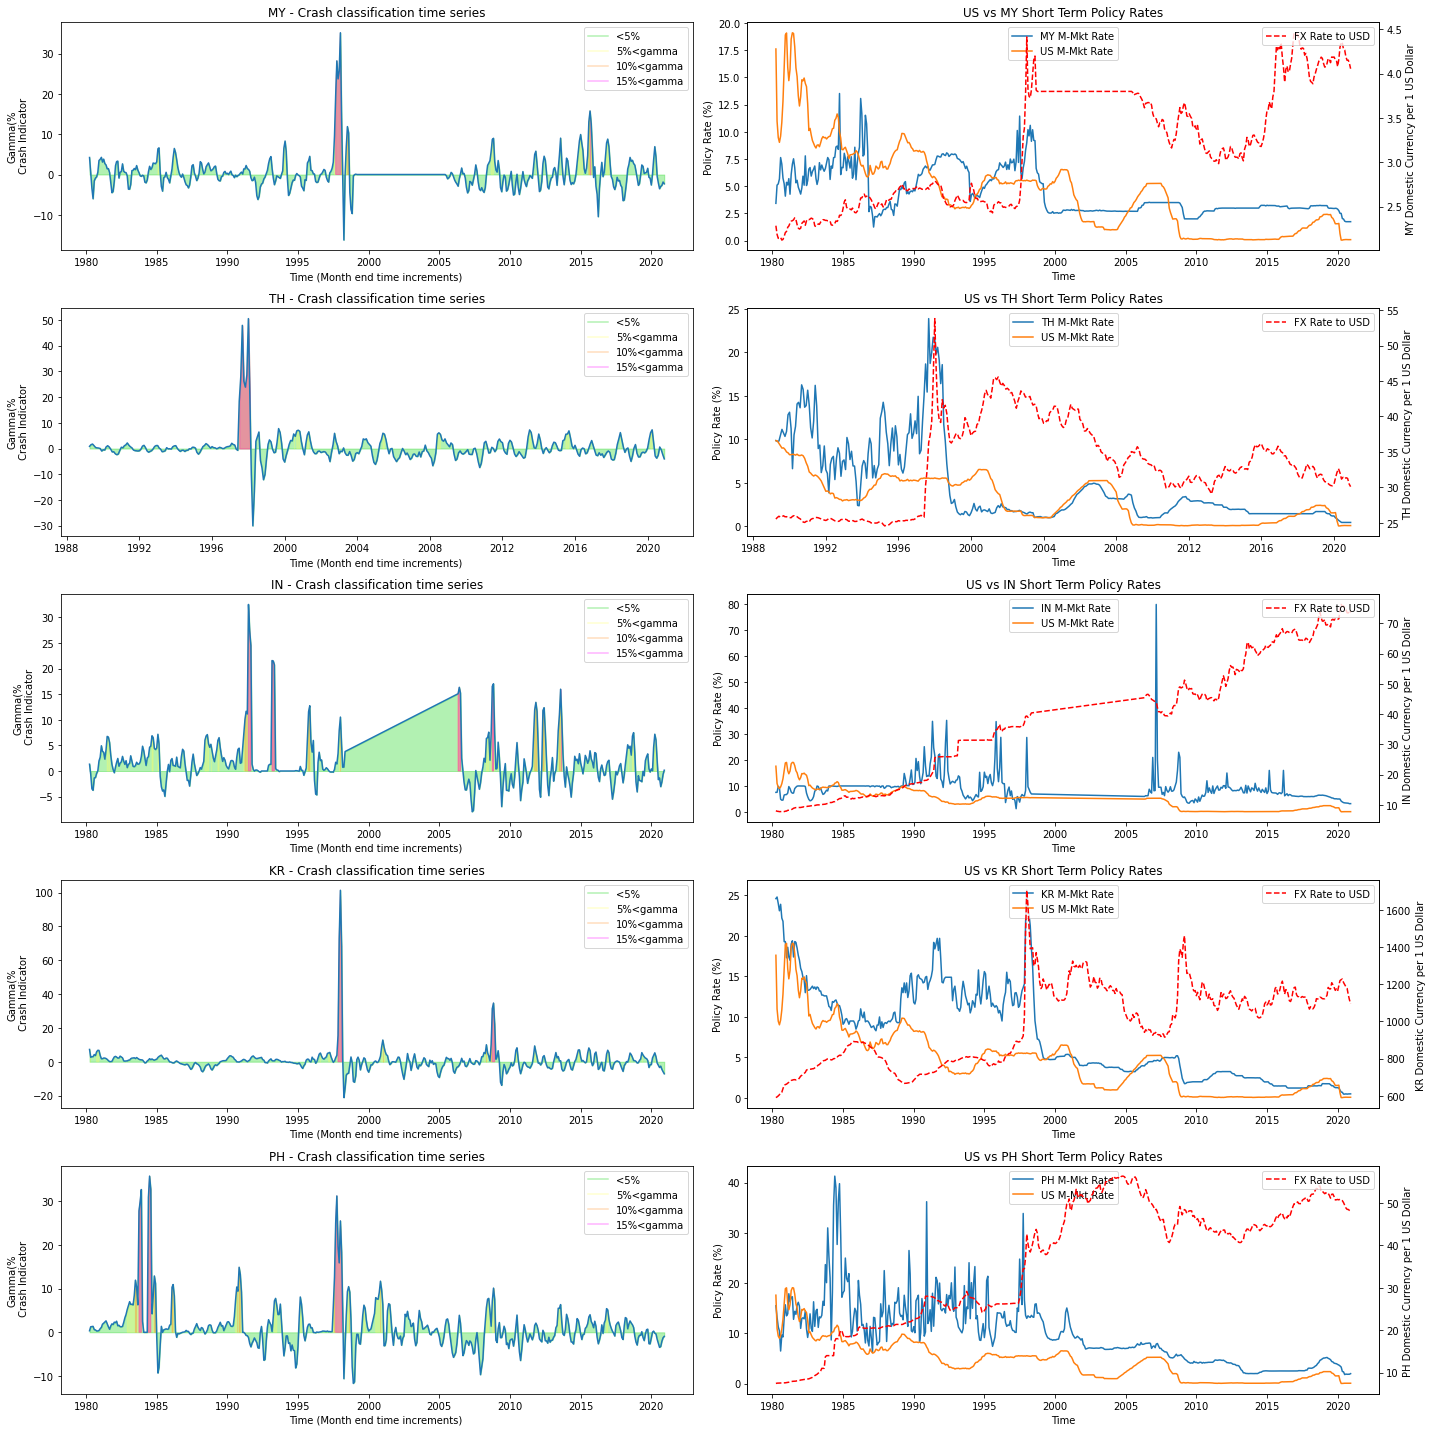

In [ ]:
#South Asia OR 'East Asia & Pacific'
SASIA = EM_MMK_1980_2020[EM_MMK_1980_2020['region'].str.contains('South Asia')|EM_MMK_1980_2020['region'].str.contains('East Asia & Pacific')]
plot_crash_and_rates(SASIA)

#'East Asia & Pacific'

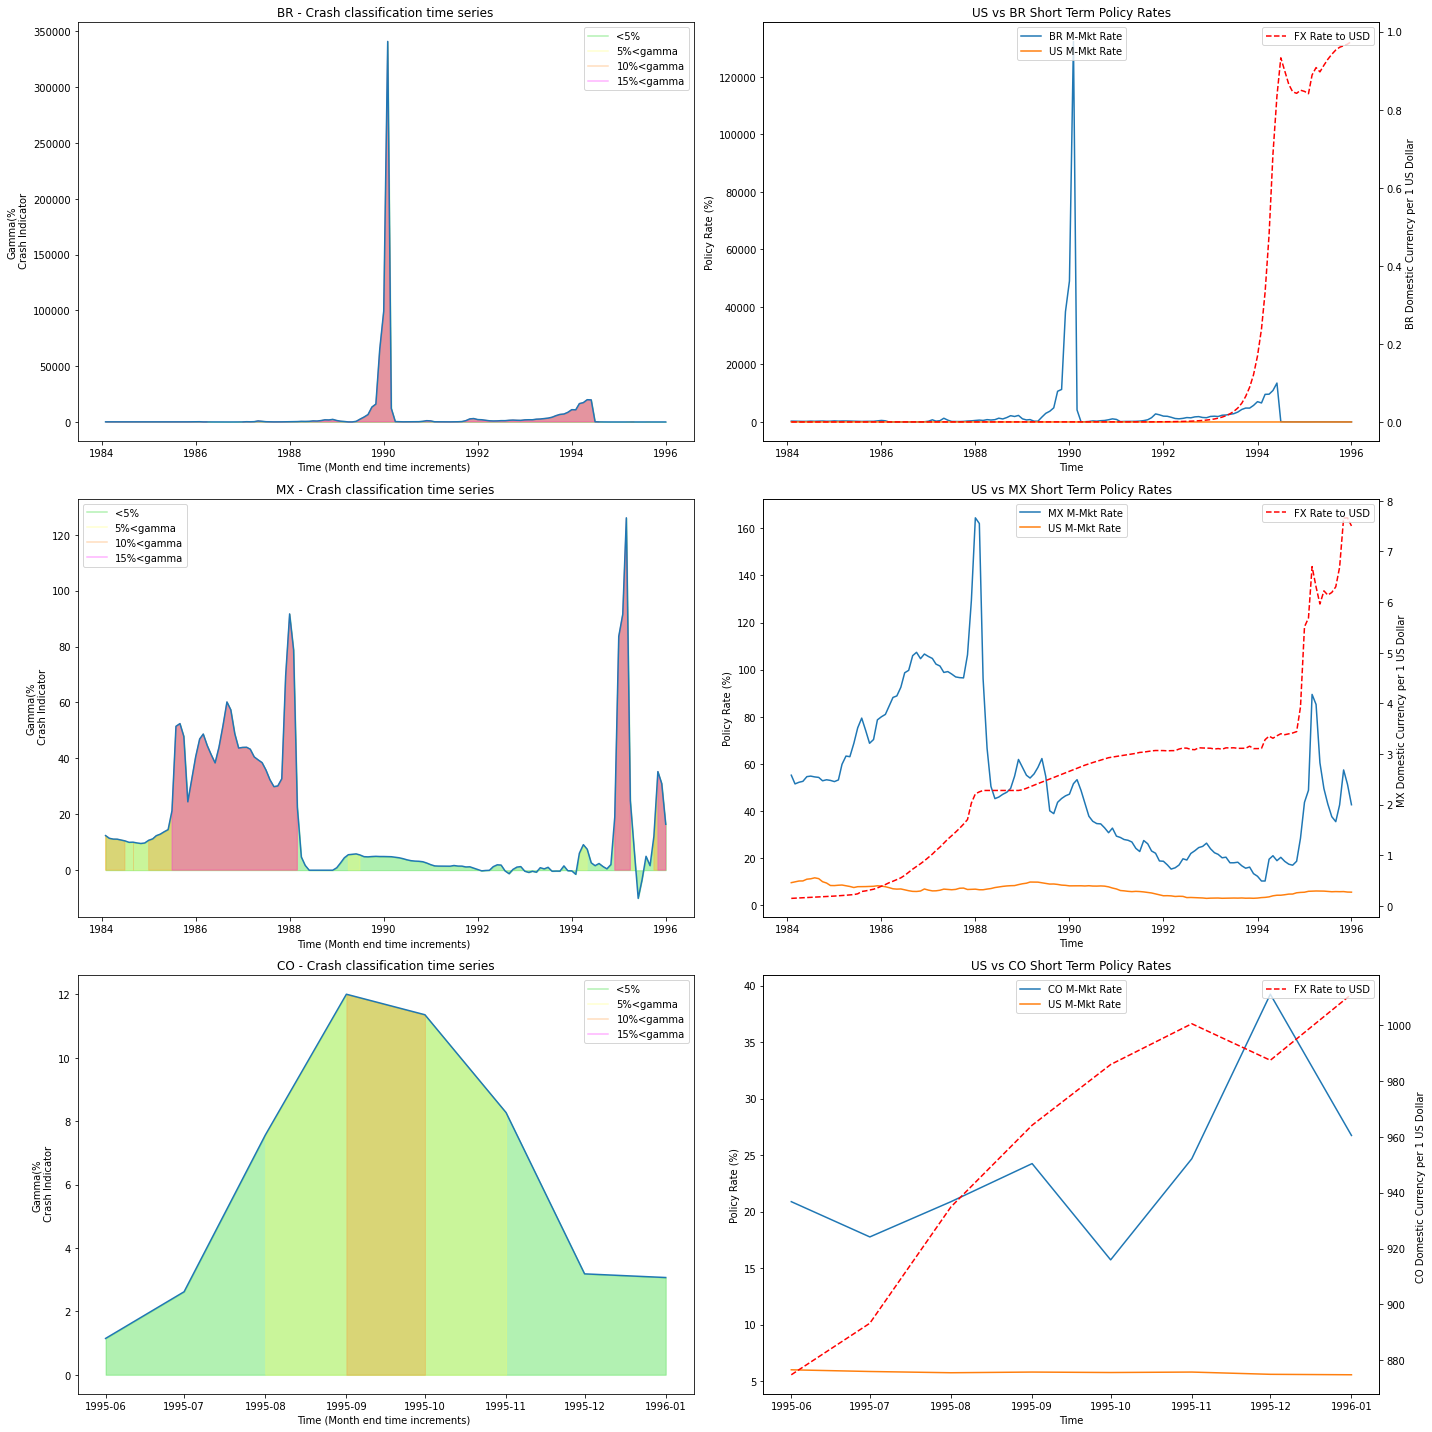

In [ ]:
# Latin American Crisis of the 1990's
Tequila  = EM_MMK_1980_2020[EM_MMK_1980_2020['region'].str.contains('Latin America & Caribbean')]
Tequila  = Tequila[Tequila ['Year'].between('1984-01-01','1996-01-01')].sort_values(by=['Year','Country'])
Tequila.dropna(subset=['gamma'], inplace = True, axis=0)
plot_crash_and_rates(Tequila)

In [ ]:
braz = EM_MMK_1980_2020[EM_MMK_1980_2020['Country'].str.contains('BR')]
braz = braz[braz['Year'].between('1984-01-01','2000-01-01')].sort_values(by=['Year','Country'])
braz.dropna(subset=['gamma'], inplace = True, axis=0)
braz
#plot_crash_and_rates(braz)

Year Country     FIMM_PA  ENDA_XDC_USD_RATE  \
49   1984-02      BR  295.481908       4.893405e-10   
50   1984-03      BR  259.806220       5.496837e-10   
51   1984-04      BR  217.976067       6.005712e-10   
52   1984-05      BR  206.058165       6.537739e-10   
53   1984-06      BR  219.712925       7.117715e-10   
..       ...     ...         ...                ...   
236  1999-09      BR   19.380000       1.897300e+00   
237  1999-10      BR   18.910000       1.968710e+00   
238  1999-11      BR   18.950000       1.929090e+00   
239  1999-12      BR   18.990000       1.842030e+00   
240  2000-01      BR   18.940000       1.802924e+00   

     USA - Money Market Rate - FIMM_PA    % Diff  Dom_rate  US_rate  \
49                                9.59  2.583616  3.954819   1.0959   
50                                9.91  2.171061  3.598062   1.0991   
51                               10.29  2.188394  3.179761   1.1029   
52                               10.32  2.182950  3.060582   1.1032   
53                               11.06  2.176554  3.197129   1.1106   
..                                 ...       ...       ...      ...   
236                               5.22  0.606656  1.193800   1.0522   
237                               5.20  0.656606  1.189100   1.0520   
238                               5.42  0.616059  1.189500   1.0542   
239                               5.30  0.528149  1.189900   1.0530   
240                               5.45  0.201056  1.189400   1.0545   

     rate ratio       gamma Defined_cut                      region  
49     3.608741  932.360219         Red  Latin America & Caribbean   
50     3.273644  710.727939         Red  Latin America & Caribbean   
51     2.883091  630.933867         Red  Latin America & Caribbean   
52     2.774276  605.610697         Red  Latin America & Caribbean   
53     2.878741  626.573548         Red  Latin America & Caribbean   
..          ...         ...         ...                         ...  
236    1.134575   68.829677         Red  Latin America & Caribbean   
237    1.130323   74.217645         Red  Latin America & Caribbean   
238    1.128344   69.512668         Red  Latin America & Caribbean   
239    1.130009   59.681304         Red  Latin America & Caribbean   
240    1.127928   22.677715         Red  Latin America & Caribbean   

[192 rows x 12 columns]

In [ ]:
MEX = EM_MMK_1980_2020[EM_MMK_1980_2020['Country'].str.contains('MX')]
MEX = MEX[MEX['Year'].between('1994-01-01','1996-01-01')].sort_values(by=['Year','Country'])
MEX.dropna(subset=['gamma'], inplace = True, axis=0)
MEX

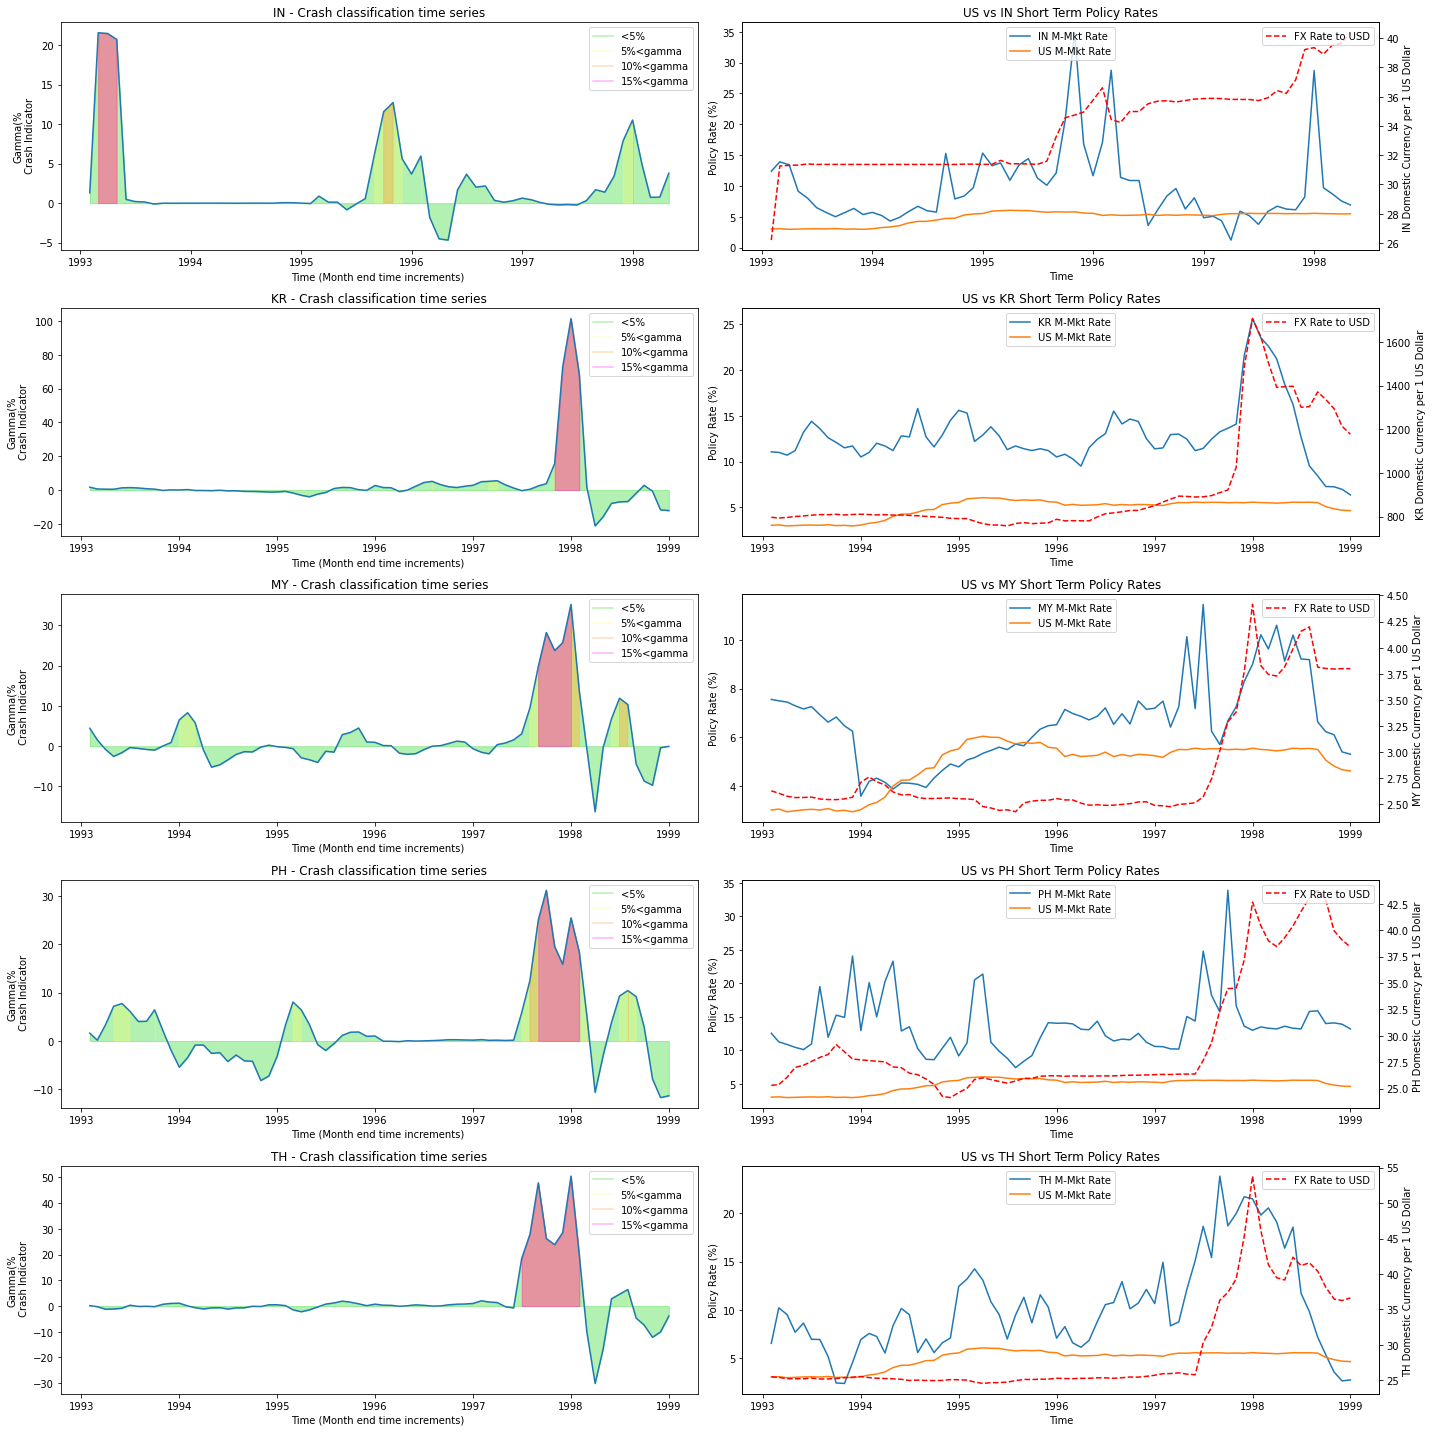

In [ ]:
#1997 Asian Financial crisis
TYK  = EM_MMK_1980_2020[EM_MMK_1980_2020['region'].str.contains('South Asia')|EM_MMK_1980_2020['region'].str.contains('East Asia & Pacific')]
TYK  = TYK[TYK ['Year'].between('1993-01-01','1999-01-01')].sort_values(by=['Year','Country'])
TYK.dropna(subset=['gamma'], inplace = True, axis=0)
plot_crash_and_rates(TYK)

In [ ]:
melted = pd.melt(EM_MMK_1980_2020.dropna(subset=['gamma'],axis=0),id_vars=['region','Country'],value_vars=['Defined_cut'] , value_name='Classification' )
melted = melted.groupby(['region','Country','Classification']).agg(Freq=('Classification','count')).reset_index().copy()


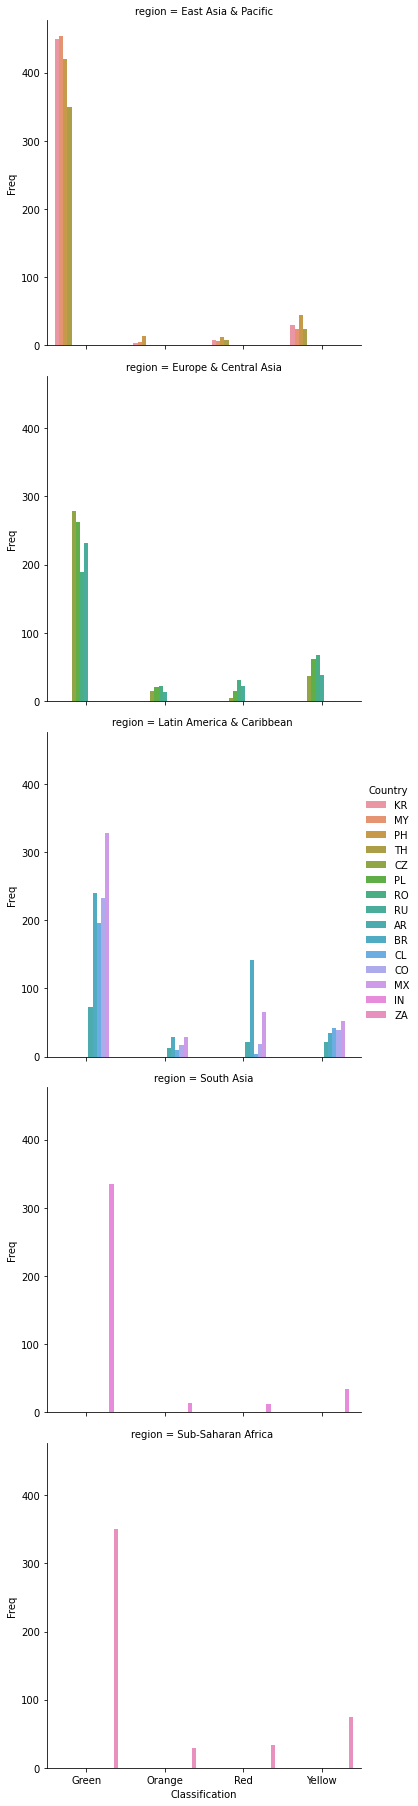

In [ ]:
sns.catplot(kind = 'bar', data = melted, 
            row = 'region',
            hue = 'Country',
            x = 'Classification',
            y = 'Freq'    
            )

In [ ]:
import plotly.express as px
fig =px.sunburst(melted, path=['region', 'Country', 'Classification'], values='Freq')
fig.show()

In [ ]:
melted

region Country Classification  Freq
0          East Asia & Pacific      KR          Green   450
1          East Asia & Pacific      KR         Orange     3
2          East Asia & Pacific      KR            Red     7
3          East Asia & Pacific      KR         Yellow    29
4          East Asia & Pacific      MY          Green   454
5          East Asia & Pacific      MY         Orange     5
6          East Asia & Pacific      MY            Red     6
7          East Asia & Pacific      MY         Yellow    24
8          East Asia & Pacific      PH          Green   420
9          East Asia & Pacific      PH         Orange    13
10         East Asia & Pacific      PH            Red    12
11         East Asia & Pacific      PH         Yellow    44
12         East Asia & Pacific      TH          Green   349
13         East Asia & Pacific      TH            Red     8
14         East Asia & Pacific      TH         Yellow    24
15       Europe & Central Asia      CZ          Green   278
16       Europe & Central Asia      CZ         Orange    15
17       Europe & Central Asia      CZ            Red     4
18       Europe & Central Asia      CZ         Yellow    36
19       Europe & Central Asia      PL          Green   262
20       Europe & Central Asia      PL         Orange    20
21       Europe & Central Asia      PL            Red    14
22       Europe & Central Asia      PL         Yellow    62
23       Europe & Central Asia      RO          Green   189
24       Europe & Central Asia      RO         Orange    22
25       Europe & Central Asia      RO            Red    31
26       Europe & Central Asia      RO         Yellow    67
27       Europe & Central Asia      RU          Green   231
28       Europe & Central Asia      RU         Orange    13
29       Europe & Central Asia      RU            Red    22
30       Europe & Central Asia      RU         Yellow    38
31  Latin America & Caribbean       AR          Green    72
32  Latin America & Caribbean       AR         Orange    13
33  Latin America & Caribbean       AR            Red    22
34  Latin America & Caribbean       AR         Yellow    22
35  Latin America & Caribbean       BR          Green   240
36  Latin America & Caribbean       BR         Orange    28
37  Latin America & Caribbean       BR            Red   141
38  Latin America & Caribbean       BR         Yellow    34
39  Latin America & Caribbean       CL          Green   196
40  Latin America & Caribbean       CL         Orange     9
41  Latin America & Caribbean       CL            Red     3
42  Latin America & Caribbean       CL         Yellow    42
43  Latin America & Caribbean       CO          Green   233
44  Latin America & Caribbean       CO         Orange    17
45  Latin America & Caribbean       CO            Red    18
46  Latin America & Caribbean       CO         Yellow    39
47  Latin America & Caribbean       MX          Green   328
48  Latin America & Caribbean       MX         Orange    29
49  Latin America & Caribbean       MX            Red    65
50  Latin America & Caribbean       MX         Yellow    52
51                  South Asia      IN          Green   335
52                  South Asia      IN         Orange    13
53                  South Asia      IN            Red    12
54                  South Asia      IN         Yellow    34
55         Sub-Saharan Africa       ZA          Green   351
56         Sub-Saharan Africa       ZA         Orange    29
57         Sub-Saharan Africa       ZA            Red    34
58         Sub-Saharan Africa       ZA         Yellow    75

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


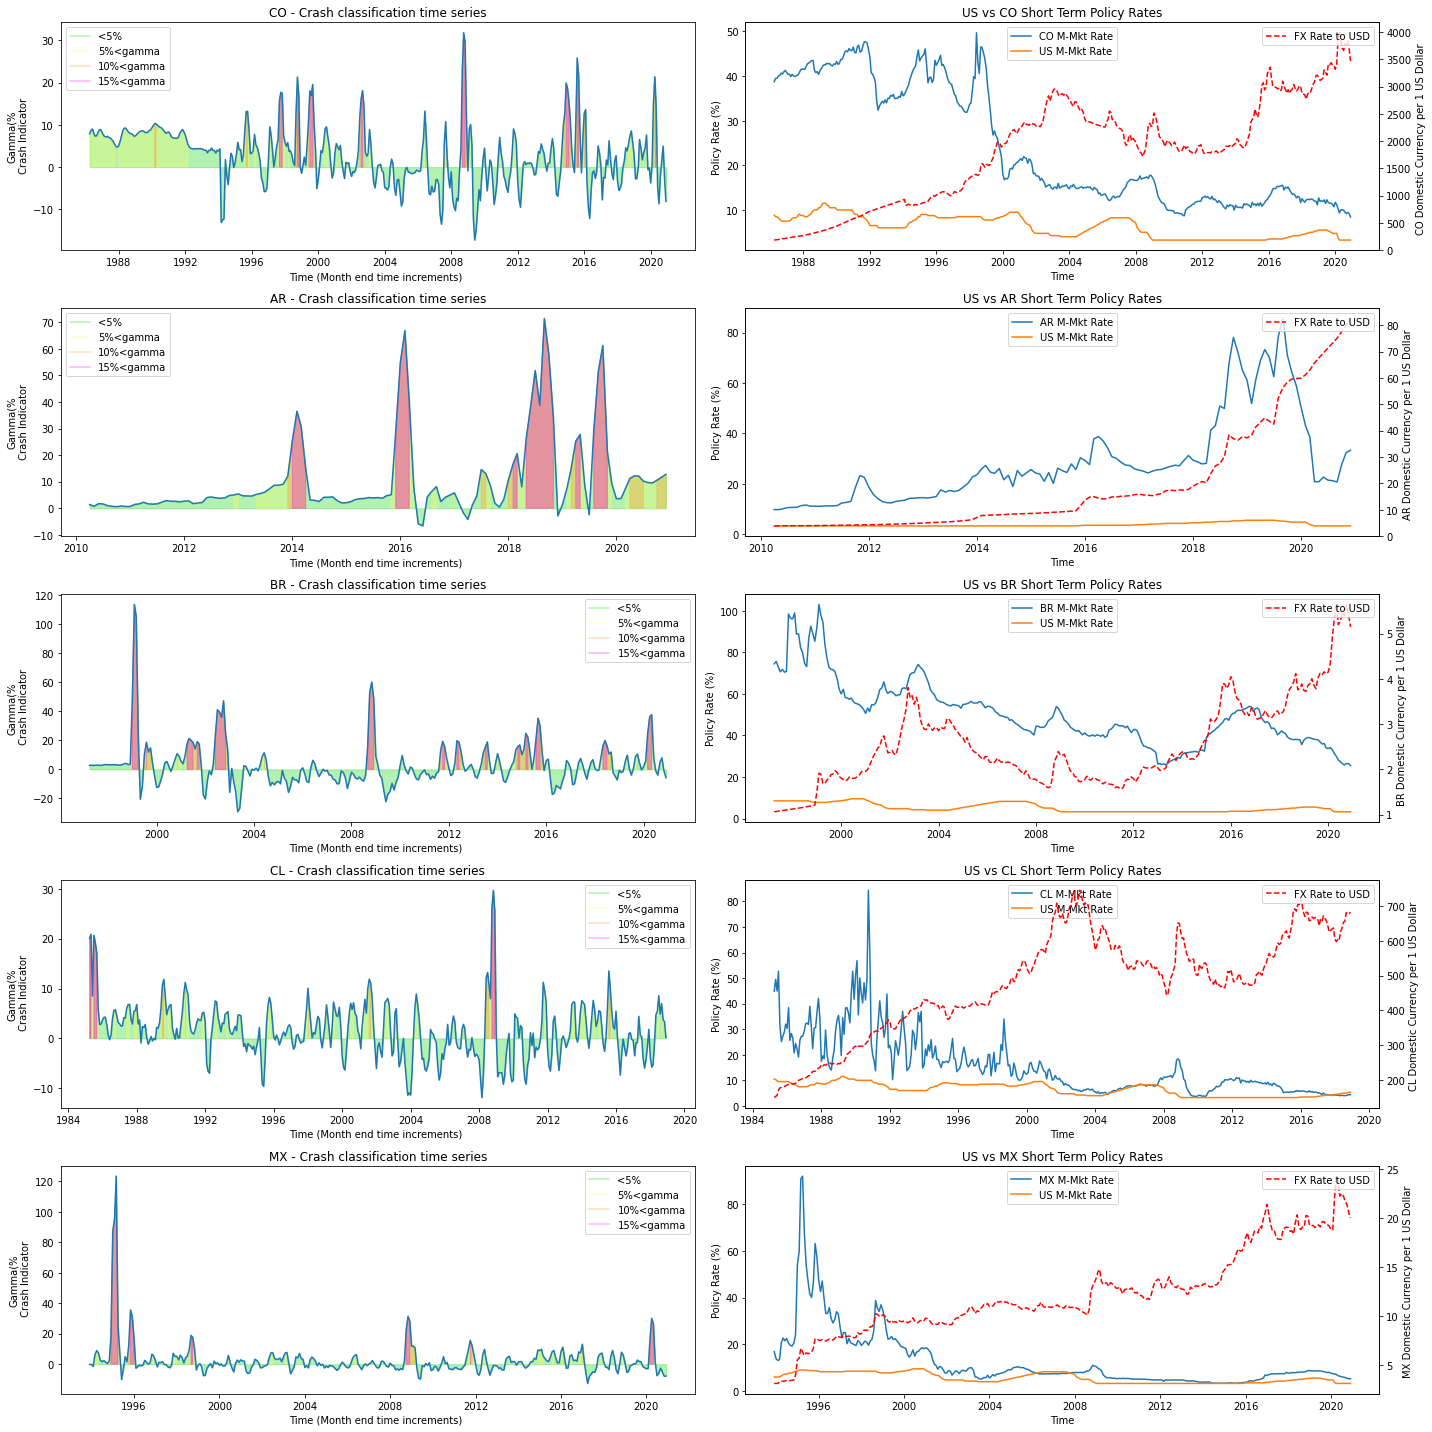

In [ ]:
test_lend = ['AR','BR','CL','MX','CO','CZ','ZA','IN', 'KR' ,'MY','PH','TH', 'IL','EG','HU' ]#] # No data for :'EG','HU','TR'
#  EG, HU- Central'RO','RU', 'PL'TR'

EM_lend_1980_2020 = multi_crash(test_lend,'1980', '2020', term='lend', frequency ='M')

LATM_lend =EM_lend_1980_2020[EM_lend_1980_2020['region'].str.contains('Latin America & Caribbean')]
plot_crash_and_rates(LATM_lend)

In [ ]:
describe_lend = EM_lend_1980_2020.dropna(subset=['gamma'],axis=0).groupby(['Country']).agg(Minimum_Date=('Year', np.min),
                                                                    Maximum_Date=('Year', np.max),
                                                                    Mean_gamma =('gamma',np.mean ),
                                                                    std_dev_gamma =('gamma',np.std )).reset_index()
  
describe_lend

Country Minimum_Date Maximum_Date  Mean_gamma  std_dev_gamma
0       AR      2010-04      2020-12   10.382596      14.995524
1       BR      1997-04      2020-12    3.266951      15.530234
2       CL      1985-04      2018-12    1.574911       5.529161
3       CO      1986-04      2020-12    2.943071       6.857098
4       CZ      1993-04      2020-12   -0.064633       5.835971
5       EG      1980-04      2020-12    2.674277      13.496634
6       HU      1988-12      2020-12    1.743838       6.445136
7       IL      2013-07      2020-05   -0.017491       2.842189
8       IN      1980-04      2020-12    1.533290       4.254877
9       KR      1996-10      2020-12    0.669552       9.256977
10      MX      1993-12      2020-12    2.590421      11.694400
11      MY      1982-03      2020-12    0.514117       4.400602
12      PH      1980-04      2019-12    1.453908       5.475954
13      TH      1980-04      2020-12    0.402141       5.283270
14      ZA      1980-04      2020-12    2.283401       8.567309

In [ ]:
melted_lend = pd.melt(EM_lend_1980_2020.dropna(subset=['gamma'],axis=0),id_vars=['region','Country'],value_vars=['Defined_cut'] , value_name='Classification' )
melted_lend = melted_lend.groupby(['region','Country','Classification']).agg(Freq=('Classification','count')).reset_index().copy()
melted_lend

region Country Classification  Freq
0          East Asia & Pacific      KR          Green   258
1          East Asia & Pacific      KR         Orange     3
2          East Asia & Pacific      KR            Red     6
3          East Asia & Pacific      KR         Yellow    24
4          East Asia & Pacific      MY          Green   393
5          East Asia & Pacific      MY         Orange     6
6          East Asia & Pacific      MY            Red     6
7          East Asia & Pacific      MY         Yellow    25
8          East Asia & Pacific      PH          Green   409
9          East Asia & Pacific      PH         Orange    13
10         East Asia & Pacific      PH            Red    13
11         East Asia & Pacific      PH         Yellow    42
12         East Asia & Pacific      TH          Green   426
13         East Asia & Pacific      TH            Red    11
14         East Asia & Pacific      TH         Yellow    27
15       Europe & Central Asia      CZ          Green   279
16       Europe & Central Asia      CZ         Orange    15
17       Europe & Central Asia      CZ            Red     4
18       Europe & Central Asia      CZ         Yellow    35
19       Europe & Central Asia      HU          Green   283
20       Europe & Central Asia      HU         Orange    22
21       Europe & Central Asia      HU            Red    10
22       Europe & Central Asia      HU         Yellow    70
23  Latin America & Caribbean       AR          Green    72
24  Latin America & Caribbean       AR         Orange    12
25  Latin America & Caribbean       AR            Red    23
26  Latin America & Caribbean       AR         Yellow    22
27  Latin America & Caribbean       BR          Green   199
28  Latin America & Caribbean       BR         Orange    19
29  Latin America & Caribbean       BR            Red    40
30  Latin America & Caribbean       BR         Yellow    27
31  Latin America & Caribbean       CL          Green   314
32  Latin America & Caribbean       CL         Orange    12
33  Latin America & Caribbean       CL            Red     8
34  Latin America & Caribbean       CL         Yellow    71
35  Latin America & Caribbean       CO          Green   268
36  Latin America & Caribbean       CO         Orange    21
37  Latin America & Caribbean       CO            Red    19
38  Latin America & Caribbean       CO         Yellow   109
39  Latin America & Caribbean       MX          Green   258
40  Latin America & Caribbean       MX         Orange     7
41  Latin America & Caribbean       MX            Red    17
42  Latin America & Caribbean       MX         Yellow    43
43  Middle East & North Africa      EG          Green   445
44  Middle East & North Africa      EG         Orange     4
45  Middle East & North Africa      EG            Red    15
46  Middle East & North Africa      EG         Yellow    21
47  Middle East & North Africa      IL          Green    78
48  Middle East & North Africa      IL         Yellow     5
49                  South Asia      IN          Green   426
50                  South Asia      IN         Orange    10
51                  South Asia      IN            Red     8
52                  South Asia      IN         Yellow    45
53         Sub-Saharan Africa       ZA          Green   351
54         Sub-Saharan Africa       ZA         Orange    28
55         Sub-Saharan Africa       ZA            Red    34
56         Sub-Saharan Africa       ZA         Yellow    76

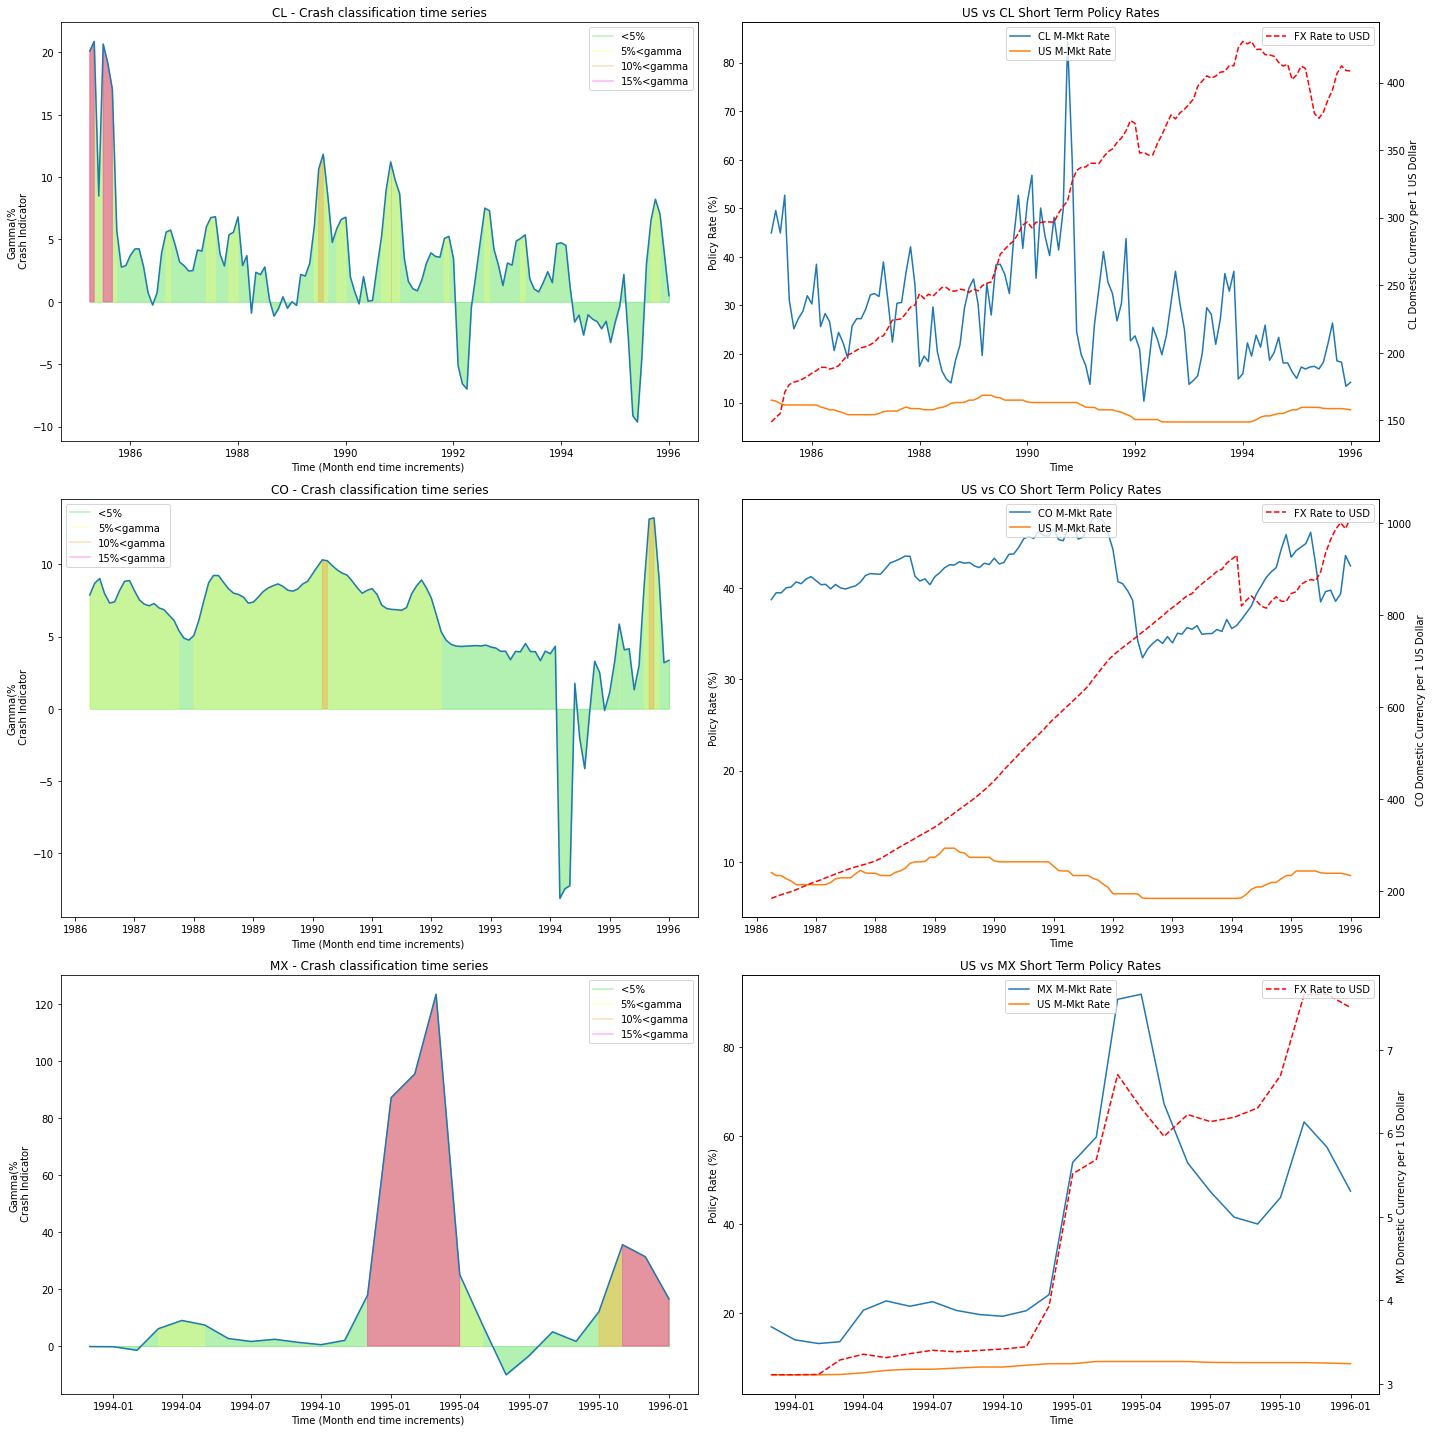

In [ ]:
# Latin American Crisis of the 1990's
Tequila_lend  = EM_lend_1980_2020[EM_lend_1980_2020['region'].str.contains('Latin America & Caribbean')]
Tequila_lend  = Tequila_lend[Tequila_lend ['Year'].between('1984-01-01','1996-01-01')].sort_values(by=['Year','Country'])
Tequila_lend.dropna(subset=['gamma'], inplace = True, axis=0)
plot_crash_and_rates(Tequila_lend)

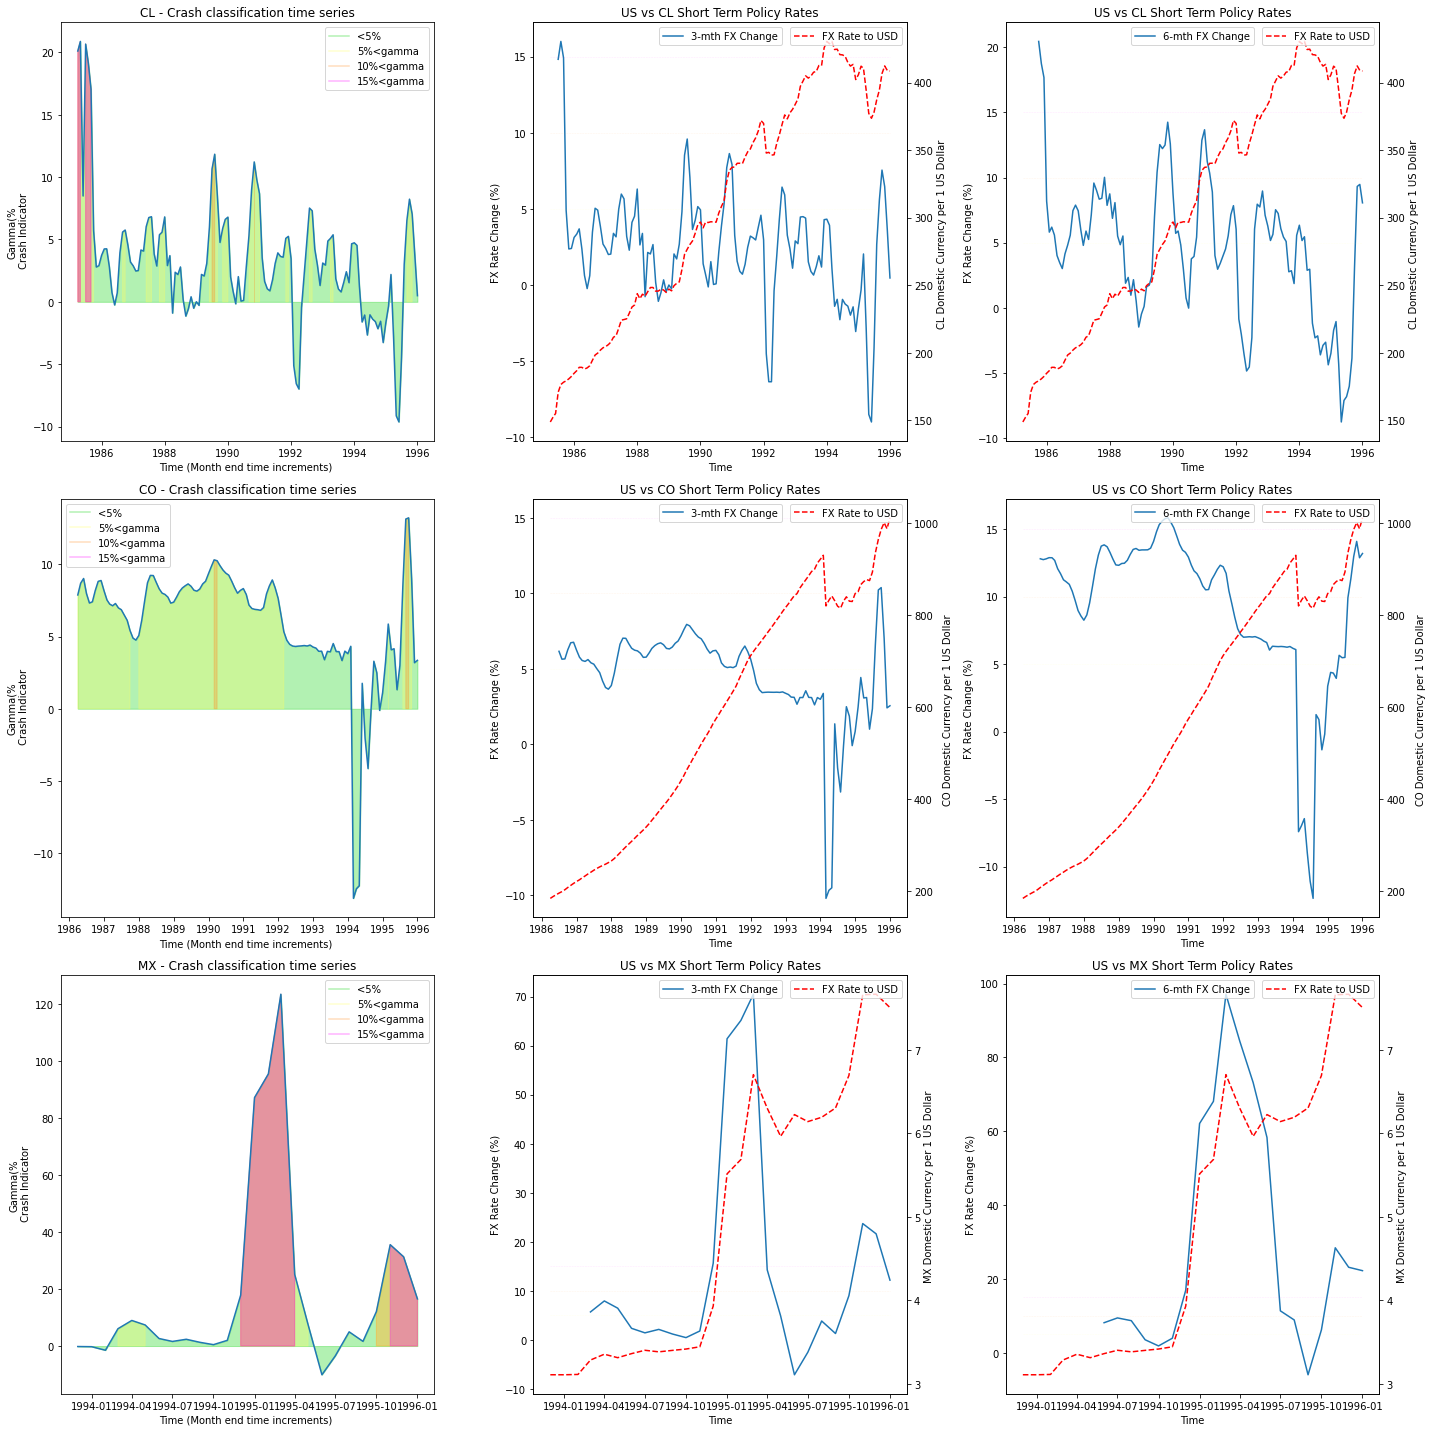

In [ ]:
plot_crash_comparisons(Tequila_lend)

In [ ]:
x = [1,2,3,4,5,6,7,8]
x = pd.Series(x).copy()
A = np.empty((len(x),1), dtype = int).fill(5)
A


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5afecb5f-7d28-4b37-ae51-8d94c0fa9663' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>